**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Redes Neuronales y Aprendizaje Profundo**

***
Datos del alumno (Nombre y Apellidos): Jose Manuel Pinillos Rubio

Fecha: 1 de mayo de 2025
***

# <span style="font-size: 20pt; font-weight: bold; color: #0098cd;">Redes Neuronales Convolucionales</span>

## Descripción de la actividad

En esta actividad, vamos a trabajar con *Convolutional Neural Networks* para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar diez clases que incluyen fundamentalmente animales y vehículos.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

El dataset a utilizar consiste en 60000 imágenes a color de 10 clases de animales y vehículos. El dataset en cuestión se denomina [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) y es más complejo que el dataset MNIST que hemos utilizado en la actividad 1. Aunque tiene las mismas clases (10), los animales y vehículos pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros animales o vehículos en pantalla (si bien el elemento a clasificar siempre aparece en la posición predominante).

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer una imagen de las incluidas en CIFAR-10 con la mayor accuracy posible. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

- Análisis de los datos a utilizar.
- Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
- Análisis visual de los errores de la red. ¿Qué tipo de imágenes dan más problemas a nuestro modelo?
- Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
- Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
- [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Te recomendamos mantener los conjuntos de entrenamiento, test y prueba que se crean en el Notebook. No obstante, si crees que modificando tales conjuntos puedes lograr mejores resultados (o que puedes lograr los mismos resultados con menos datos, lo cual es también un logro), eres libre de hacerlo.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.

## 1. Información sobre el *dataset*

El conjunto de datos **CIFAR-10** consta de **60000 imágenes en color de 32x32 píxeles**, distribuidas equitativamente en **10 clases**: avión, automóvil, ave, gato, ciervo, perro, rana, caballo, barco y camión. Cada clase contiene 6000 imágenes. El conjunto se divide en **50000 imágenes para entrenamiento** y **10000 para prueba**. Las imágenes de entrenamiento se organizan en cinco lotes de 10000 imágenes cada uno, mientras que el lote de prueba contiene 1000 imágenes seleccionadas aleatoriamente de cada clase.

## 2. Análisis exploratorio de los datos

Aunque el conjunto de datos CIFAR-10 ha sido ampliamente utilizado y está perfectamente estructurado, resulta conveniente realizar un análisis exploratorio básico que permita verificar su correcta carga y comprender su composición. Este análisis preliminar incluye la revisión de dimensiones, la visualización de ejemplos representativos, la confirmación del balance entre clases y la inspección del rango de valores de píxeles. Con ello se garantiza que los datos se encuentran en buen estado antes de proceder con su preprocesamiento y entrenamiento.

### 2.1 - Importación de librerías

In [ ]:
# -------------------- Utilidades generales --------------------
import os                                  # Operaciones del sistema para fijar variables de entorno
import random                              # Generador de números aleatorios estándar de Python
import numpy as np                         # Operaciones numéricas eficientes sobre arrays
import pandas as pd                        # Manipulación y análisis de estructuras de datos tabulares
import matplotlib.pyplot as plt            # Visualización de gráficos
import seaborn as sns                      # Visualización avanzada (mapas de calor, estilo)

# -------------------- Semillas para reproducibilidad --------------------
seed_value = 13
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# -------------------- TensorFlow y Keras --------------------
import tensorflow as tf
tf.random.set_seed(seed_value)

# -------------------- Inicialización controlada --------------------
from tensorflow.keras.initializers import GlorotUniform
model_init_random = GlorotUniform(seed=seed_value)

# -------------------- Construcción del modelo --------------------
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, LeakyReLU
)

# -------------------- Compilación y optimización --------------------
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

# -------------------- Regularización y callbacks --------------------
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, Callback

# -------------------- Utilidades para etiquetas y datos --------------------
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------- Evaluación --------------------
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

En este bloque se importan las bibliotecas necesarias para desarrollar la actividad: `Keras` y `TensorFlow` para construir y entrenar la red neuronal, `matplotlib` para visualizar imágenes, y `NumPy` y `pandas` para operaciones numéricas y análisis de datos. Además, se fijan las semillas aleatorias de `NumPy` y `TensorFlow` para mejorar la reproducibilidad de los resultados. Esto es necesario porque las redes neuronales incluyen procesos aleatorios internos, como la inicialización de pesos o la partición de validación, que no permiten especificar una semilla local como en otros algoritmos tradicionales. Por este motivo, las semillas deben establecerse de forma global antes de ejecutar cualquier operación. No obstante, al trabajar en entornos como Google Colab (mi caso) con aceleración por GPU, pueden mantenerse pequeñas variaciones entre ejecuciones, ya que algunas operaciones paralelizadas no son completamente deterministas.Explicar el bloque de codigo a mi estilo.

### 2.2 - Carga de los datos

In [ ]:
# Importamos del dataset CIFAR-10 (60.000 imágenes en 10 clases)
from keras.datasets import cifar10

# Definimos los datos de entrenamiento, validación y prueba
(X, Y), (x_test, y_test) = cifar10.load_data()
(x_train, x_valid) = (X[:40000], X[40000:])
(y_train, y_valid) = (Y[:40000], Y[40000:])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Este fragmento de código realiza la carga y partición del conjunto de datos **CIFAR-10**, utilizado para entrenar y evaluar una red neuronal convolucional. La función `cifar10.load_data()` devuelve dos tuplas: una correspondiente a los datos de entrenamiento (`X`, `Y`) y otra con los datos de prueba (`x_test`, `y_test`). Las variables `X` y `Y` contienen las imágenes y etiquetas, respectivamente, del conjunto de entrenamiento completo (60.000 imágenes en total).

Posteriormente, se realiza una partición manual del conjunto de entrenamiento: se toman las primeras 40.000 imágenes (`X[:40000]`) y sus correspondientes etiquetas (`Y[:40000]`) como **conjunto de entrenamiento** (`x_train`, `y_train`), y las 20.000 imágenes restantes (`X[40000:]`, `Y[40000:]`) como **conjunto de validación** (`x_valid`, `y_valid`). Esta separación permite reservar una parte de los datos para evaluar el desempeño del modelo durante el entrenamiento, sin utilizar aún los datos de prueba finales (`x_test`, `y_test`), que se emplearán únicamente al finalizar el entrenamiento para medir la generalización del modelo.

Esta forma de división garantiza que el conjunto de validación sea representativo y equilibrado, dado que se extrae de forma secuencial de un dataset aleatorizado. Además, al mantener separados los datos de prueba, se evita cualquier fuga de información durante el proceso de ajuste del modelo.

### 2.3 - Comprobación de estructura y clases del dataset

In [ ]:
# Mostramos información sobre los conjuntos de entrenamiento, validación y prueba
print(f"Total de imágenes de entrenamiento: {x_train.shape[0]}")
print(f"Total de imágenes de validación: {x_valid.shape[0]}")
print(f"Total de imágenes de prueba: {x_test.shape[0]}")

print(f"Número de clases en el conjunto de entrenamiento: {len(np.unique(y_train))}")
print(f"Número de clases en el conjunto de validación: {len(np.unique(y_valid))}")
print(f"Número de clases en el conjunto de prueba: {len(np.unique(y_test))}")

Total de imágenes de entrenamiento: 40000
Total de imágenes de validación: 10000
Total de imágenes de prueba: 10000
Número de clases en el conjunto de entrenamiento: 10
Número de clases en el conjunto de validación: 10
Número de clases en el conjunto de prueba: 10


El código imprime un resumen informativo sobre la cantidad de imágenes y la diversidad de clases en los conjuntos de datos tras su partición. Se utiliza `shape[0]` para obtener el número total de imágenes (es decir, la primera dimensión del array), y `np.unique()` para contar cuántas clases distintas hay en cada conjunto según las etiquetas disponibles. Esto permite confirmar rápidamente que se han cargado y separado correctamente los datos, y que se mantienen representadas todas las clases previstas (en este caso, 10).

### 2.4 - Verificación de dimensiones y formatos

In [ ]:
# Verificación de dimensiones y formatos de los conjuntos de datos
print(f"Forma de x_train: {x_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

print(f"Forma de x_valid: {x_valid.shape}")
print(f"Forma de y_valid: {y_valid.shape}")

print(f"Forma de x_test: {x_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de x_train: (40000, 32, 32, 3)
Forma de y_train: (40000, 1)
Forma de x_valid: (10000, 32, 32, 3)
Forma de y_valid: (10000, 1)
Forma de x_test: (10000, 32, 32, 3)
Forma de y_test: (10000, 1)


Este bloque permite comprobar que las matrices de imágenes y etiquetas presentan la forma esperada tras la carga y partición del dataset. Las imágenes de CIFAR-10 deben tener forma `(n, 32, 32, 3)`, donde `n` es el número de muestras y cada imagen tiene 32x32 píxeles con 3 canales de color (RGB). Las etiquetas deben tener forma `(n, 1)` si se mantienen sin aplanar. Esta verificación garantiza que no ha ocurrido ninguna alteración accidental en el proceso de separación.

### 2.5 - Visualización de ejemplos

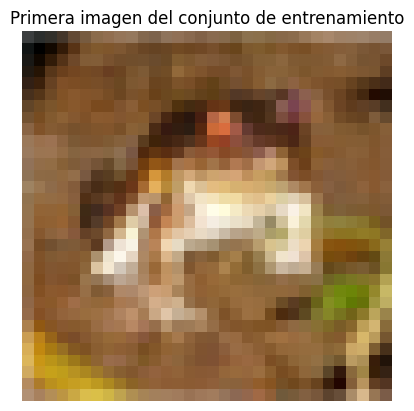

In [ ]:
# Aumentamos el ancho de impresión para mostrar matrices completas en consola
np.set_printoptions(linewidth=200)

# Mostramos la primera imagen del conjunto de entrenamiento
plt.imshow(x_train[0])
plt.title("Primera imagen del conjunto de entrenamiento")
plt.axis("off")
plt.show()

En esta fase inicial, visualizar gráficamente una imagen del conjunto de entrenamiento permite comprobar que los datos se han cargado correctamente y que las imágenes conservan su forma, color y contenido esperados. Dado que CIFAR-10 contiene imágenes RGB, no se aplica una conversión a escala de grises para evitar distorsionar la representación original. El uso de `plt.axis("off")` oculta los ejes para facilitar la visualización limpia de la imagen. Imprimir directamente los valores de los píxeles resultaría poco informativo y difícil de interpretar, por lo que se omite en esta etapa.

### 2.6 - Distribución de clases

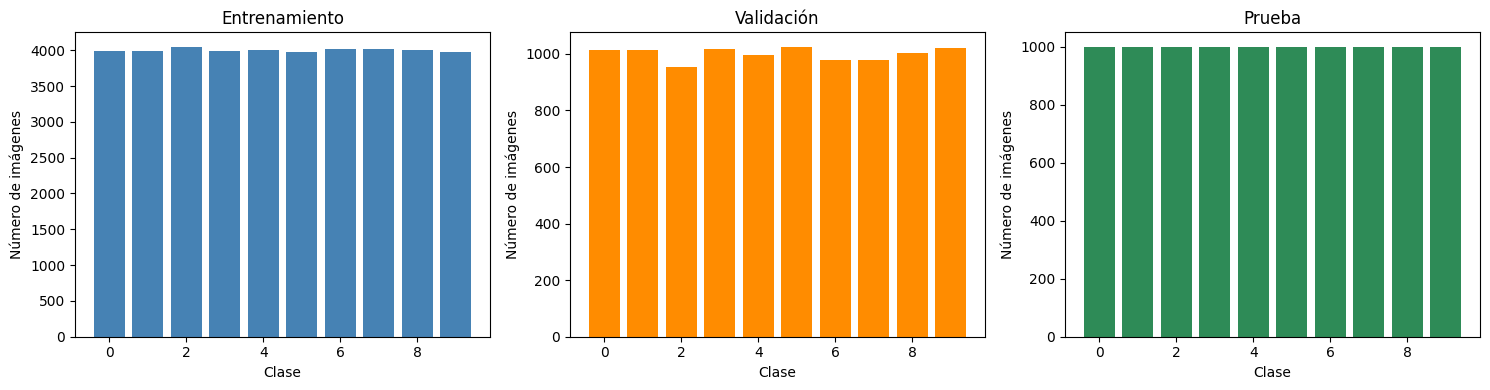

In [ ]:
# Mostramos la cantidad de imágenes por clase en entrenamiento, validación y prueba
clases_entrenamiento, conteo_entrenamiento = np.unique(y_train, return_counts=True)
clases_validacion, conteo_validacion = np.unique(y_valid, return_counts=True)
clases_test, conteo_test = np.unique(y_test, return_counts=True)

# Visualizamos la distribución de clases
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.bar(clases_entrenamiento, conteo_entrenamiento, color="steelblue")
plt.title("Entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")

plt.subplot(1, 3, 2)
plt.bar(clases_validacion, conteo_validacion, color="darkorange")
plt.title("Validación")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")

plt.subplot(1, 3, 3)
plt.bar(clases_test, conteo_test, color="seagreen")
plt.title("Prueba")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")

plt.tight_layout()
plt.show()

El código representa gráficamente la distribución de clases en los tres subconjuntos del dataset: entrenamiento, validación y prueba. Primero se utiliza `np.unique` con el parámetro `return_counts=True` para obtener las etiquetas únicas y su frecuencia en cada subconjunto. Esto permite confirmar de forma programática que las 10 clases están presentes en proporciones similares.

A continuación, se construyen tres diagramas de barras, uno para cada conjunto, dispuestos en una sola fila con tres columnas. Cada gráfico muestra en el eje X las clases (codificadas del 0 al 9) y en el eje Y el número de imágenes asociadas. Los colores diferenciados facilitan su comparación visual: azul para entrenamiento, naranja para validación y verde para prueba.

La visualización muestra la distribución de clases en los tres subconjuntos del dataset CIFAR-10 tras su partición manual. En el conjunto de entrenamiento, las barras presentan alturas prácticamente idénticas entre las 10 clases, lo que confirma una distribución equilibrada con aproximadamente 4.000 imágenes por clase. En el conjunto de validación, aunque el reparto también es uniforme, se observan ligeras variaciones entre clases (del orden de ±50 imágenes), lo cual es razonable dado que la partición se ha hecho por índice, sin reordenar los datos aleatoriamente. Aun así, las diferencias son pequeñas y no comprometen la representatividad del conjunto.

En el conjunto de prueba, el equilibrio es absoluto: cada clase cuenta con exactamente 1.000 imágenes, como es característico de CIFAR-10. Esto garantiza que la evaluación final del modelo se realice en condiciones simétricas para todas las categorías, evitando sesgos en la métrica de rendimiento por sobrerrepresentación de alguna clase.

En conjunto, los resultados confirman que la carga y segmentación de los datos se ha realizado correctamente, manteniendo un equilibrio suficiente en todas las particiones.

### 2.7 - Rangos de valores de píxeles

In [ ]:
# Mostramos los valores mínimo y máximo de píxeles en cada subconjunto
print(f"Rango en x_train: [{x_train.min()}, {x_train.max()}]")
print(f"Rango en x_valid: [{x_valid.min()}, {x_valid.max()}]")
print(f"Rango en x_test:  [{x_test.min()}, {x_test.max()}]")

Rango en x_train: [0, 255]
Rango en x_valid: [0, 255]
Rango en x_test:  [0, 255]


Este bloque de código utiliza `.min()` y `.max()` para obtener el rango completo de intensidades presentes en las matrices RGB originales. Dado que las imágenes de CIFAR-10 están codificadas en formato de 8 bits por canal, los valores esperados deben encontrarse entre 0 (ausencia total de intensidad) y 255 (intensidad máxima).

Los resultados `[0, 255]` en los tres subconjuntos confirman que los datos se encuentran en su forma cruda original, sin transformaciones previas de tipo escalado o conversión de formato. Esta verificación respalda la necesidad de aplicar una normalización explícita antes del entrenamiento del modelo, normalmente dividiendo por 255.0 para llevar los valores al rango `[0, 1]`, mejorando así la estabilidad del proceso de optimización.

### 2.8 - Comprobación de valores nulos

In [ ]:
# Verificamos si hay valores nulos en los conjuntos de imágenes y etiquetas
print(f"¿Hay valores nulos en x_train? {np.isnan(x_train).any()}")
print(f"¿Hay valores nulos en y_train? {np.isnan(y_train).any()}")

print(f"¿Hay valores nulos en x_valid? {np.isnan(x_valid).any()}")
print(f"¿Hay valores nulos en y_valid? {np.isnan(y_valid).any()}")

print(f"¿Hay valores nulos en x_test? {np.isnan(x_test).any()}")
print(f"¿Hay valores nulos en y_test? {np.isnan(y_test).any()}")

¿Hay valores nulos en x_train? False
¿Hay valores nulos en y_train? False
¿Hay valores nulos en x_valid? False
¿Hay valores nulos en y_valid? False
¿Hay valores nulos en x_test? False
¿Hay valores nulos en y_test? False


El código emplea la función `np.isnan()` que detecta la presencia de valores *NaN* en los arrays. Posteriormente, se utiliza `.any()` para verificar si hay al menos un valor nulo en cada uno de ellos.

La revisión se realiza tanto sobre las imágenes (`x_train`, `x_valid`, `x_test`) como sobre sus respectivas etiquetas (`y_train`, `y_valid`, `y_test`), cubriendo así todas las posibles fuentes de inconsistencia en los datos.

Los resultados devueltos son `False` en todos los casos, lo que indica que **no se han encontrado valores nulos en ninguno de los subconjuntos**. Esta comprobación rápida confirma que no será necesario aplicar técnicas de imputación o filtrado, y que los datos están completamente definidos, listos para ser normalizados y utilizados en el entrenamiento sin riesgos de errores por ausencia de valores.

## 3. Preprocesamiento

### 3.1 - Normalización

In [ ]:
# Normalizamos los datos escalando los valores de píxeles al rango [0, 1]
x_train_norm = x_train / 255.0
x_valid_norm = x_valid / 255.0
x_test_norm  = x_test / 255.0

# Comprobamos el rango de valores tras la normalización
print(f"Rango en x_train_norm: [{x_train_norm.min()}, {x_train_norm.max()}]")
print(f"Rango en x_valid_norm: [{x_valid_norm.min()}, {x_valid_norm.max()}]")
print(f"Rango en x_test_norm:  [{x_test_norm.min()}, {x_test_norm.max()}]")

Rango en x_train_norm: [0.0, 1.0]
Rango en x_valid_norm: [0.0, 1.0]
Rango en x_test_norm:  [0.0, 1.0]


Este bloque de código realiza la normalización de los datos, transformando los valores de los píxeles de su escala original \[0, 255] al rango \[0, 1]. Para ello, se divide cada valor por `255.0`, generando nuevos arrays (`x_train_norm`, `x_valid_norm`, `x_test_norm`) que contienen las versiones normalizadas de las imágenes. Esta operación no modifica los datos originales, lo que permite conservar una copia sin escalar para referencia o inspección posterior.

Tras la normalización, se comprueba el rango de valores de cada conjunto mediante `.min()` y `.max()`.

Los resultados confirman que la normalización se ha aplicado correctamente. Los valores mínimo y máximo en los tres subconjuntos (`x_train_norm`, `x_valid_norm`, `x_test_norm`) abarcan el intervalo completo `[0.0, 1.0]`, lo que indica que los píxeles han sido reescalados de forma lineal desde su rango original de `[0, 255]`.

Esto asegura que los datos están en una escala adecuada para ser procesados por la red neuronal, lo cual favorece una convergencia más estable y eficiente durante el entrenamiento. Además, al mantener el mismo rango en los tres conjuntos, se garantiza la coherencia entre las fases de entrenamiento, validación y prueba, sin riesgo de desajustes numéricos. La decisión de almacenar los datos normalizados en nuevas variables, sin sobrescribir los originales, permite preservar trazabilidad y comparaciones posteriores si fueran necesarias.

### 3.2 - Diccionario de clases (etiquetas humanas)

In [ ]:
# Diccionario que asocia cada etiqueta numérica con su clase correspondiente
MAP_ELEMENTS = {
    0: 'avion', 1: 'coche', 2: 'ave',
    3: 'gato', 4: 'ciervo', 5: 'perro', 6: 'rana',
    7: 'caballo', 8: 'barco', 9: 'camion'
}

Este diccionario proporciona una correspondencia entre las etiquetas numéricas utilizadas internamente por CIFAR-10 (del 0 al 9) y los nombres comprensibles de cada clase (como "avion", "coche", "perro", etc.). Esta estructura resulta especialmente útil durante el análisis exploratorio o la visualización de imágenes clasificadas, ya que permite traducir los números en categorías fácilmente interpretables por humanos.

Aunque no es estrictamente necesario para el entrenamiento del modelo, este mapeo facilita tareas como mostrar imágenes etiquetadas, interpretar predicciones, generar informes o depurar errores. Incluir esta asociación en una variable externa como `MAP_ELEMENTS` permite su reutilización a lo largo del cuaderno o proyecto sin codificar manualmente las clases cada vez.

### 3.3 - Función para codificación *one-hot* de etiquetas

In [ ]:
# Función auxiliar para convertir etiquetas numéricas en vectores one-hot
def convert_to_one_hot(labels, num_classes):

    # Inicializamos una lista vacía para almacenar las etiquetas codificadas
    codificadas = []

    # Recorremos cada etiqueta individualmente
    for label in labels:
        # Convertimos la etiqueta numérica a un vector one-hot usando Keras
        vector = to_categorical(label, num_classes=num_classes)
        # Añadimos el vector resultante a la lista
        codificadas.append(vector)

    # Convertimos la lista de vectores en un array de NumPy
    codificadas = np.array(codificadas)

    # Eliminamos dimensiones innecesarias (por ejemplo, de forma (n, 1, 10) a (n, 10))
    return np.squeeze(codificadas)

Esta función transforma etiquetas numéricas simples (por ejemplo, `3` para “gato”) en vectores de tipo *one-hot*, un formato requerido para entrenar redes neuronales en tareas de clasificación multiclase. La codificación *one-hot* representa cada clase mediante un vector binario en el que solo una posición contiene el valor 1, correspondiente a la clase activa, y el resto son ceros. Por ejemplo, la etiqueta `3` se convierte en `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

En la implementación, la función recorre cada etiqueta en la lista y aplica `to_categorical()` de Keras para generar su codificación. Estos vectores se almacenan en una lista, que luego se transforma en un array de NumPy. Finalmente, se aplica `np.squeeze()` para eliminar cualquier dimensión innecesaria, garantizando que la forma del array resultante sea compatible con la entrada que espera la red neuronal.

Esta función permite reutilizar el proceso de conversión para cualquier conjunto de etiquetas, simplemente pasando la lista correspondiente y el número total de clases.

### 3.4 - Aplicación de la codificación *one-hot* a las etiquetas

In [ ]:
# Número total de clases
num_classes = 10

# Aplicamos la codificación one-hot a cada conjunto de etiquetas
y_train_one_hot = convert_to_one_hot(y_train, num_classes)
y_valid_one_hot = convert_to_one_hot(y_valid, num_classes)
y_test_one_hot  = convert_to_one_hot(y_test, num_classes)

# Verificamos la forma de las matrices resultantes
print(y_train_one_hot.shape)
print(y_valid_one_hot.shape)
print(y_test_one_hot.shape)


(40000, 10)
(10000, 10)
(10000, 10)


En este bloque se aplica la función definida anteriormente para transformar las etiquetas de los tres subconjuntos (`y_train`, `y_valid`, `y_test`) en sus respectivas versiones *one-hot*. Se especifica que hay un total de 10 clases, lo que implica que cada etiqueta pasará a representarse mediante un vector de 10 posiciones.

El resultado de esta transformación son tres arrays: `y_train_one_hot`, `y_valid_one_hot` y `y_test_one_hot`, que contienen las etiquetas ya codificadas y listas para ser utilizadas en el entrenamiento y evaluación de la red neuronal. Finalmente, se imprime la forma de cada uno para confirmar que se ha realizado correctamente la transformación. Cada fila representa una muestra, y cada columna una clase posible. Si la conversión es correcta, la forma esperada será `(n, 10)` en cada caso, siendo `n` el número de muestras del conjunto correspondiente.

## 4. Diseño y entrenamiento del modelo

En esta sección se construye, entrena y evalúa una red neuronal convolucional (*Convolutional Neural Network*, CNN) diseñada específicamente para resolver el problema de clasificación de imágenes en el conjunto CIFAR-10. El enfoque adoptado se basa en un modelo *secuencial*, donde las capas se apilan de forma lineal, reflejando una arquitectura clara y fácilmente interpretable.

El diseño del modelo comienza con el uso de capas `Conv2D`, que se encargan de detectar patrones visuales relevantes (bordes, texturas, formas) a través de la aplicación de filtros sobre la imagen. Estas capas extraen progresivamente características de mayor nivel conforme se avanza en profundidad en la red.

Tras cada capa convolucional, se incluye una capa `MaxPooling2D`, que reduce la dimensionalidad espacial de las representaciones, manteniendo la información más significativa. Esta operación disminuye el coste computacional y aporta invariancia a pequeñas transformaciones o desplazamientos en las imágenes.

Una vez completado el bloque convolucional, se utiliza `Flatten` para transformar las salidas bidimensionales en un vector unidimensional, adecuado para ser procesado por capas densamente conectadas.

A continuación, se incorpora una capa `Dense` intermedia, que realiza una primera integración de las características extraídas. Justo antes de la capa de salida, se aplica `Dropout` como técnica de regularización, reduciendo el riesgo de sobreajuste al desactivar aleatoriamente un subconjunto de neuronas durante el entrenamiento.

Finalmente, la capa de salida `Dense` utiliza activación `softmax` y cuenta con 10 neuronas, una por cada clase del problema, permitiendo obtener una distribución de probabilidad sobre las posibles categorías de cada imagen.

Este diseño modular y jerárquico permite que la red aprenda de forma progresiva desde patrones simples hasta representaciones de alto nivel, adecuadas para resolver tareas complejas como la clasificación multiclase de imágenes naturales.

### 4.1 - Definición de la arquitectura de la red

#### 4.1.1 - Fase convolucional (extracción de características)

In [ ]:
# Definimos el modelo como una secuencia de capas
model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
model.add(Flatten())

El modelo comienza con una capa `Input` que define explícitamente el tamaño de las imágenes de entrada: 32 píxeles de ancho por 32 de alto y 3 canales correspondientes al color en formato RGB. Esta capa no realiza operaciones, pero establece la estructura base que debe respetar toda la red.

A continuación, se añade la primera capa convolucional (`Conv2D`), que aplica 32 filtros de tamaño 3x3 con activación ReLU y una inicialización controlada mediante `model_init_random`, lo que garantiza que los pesos iniciales sean siempre los mismos al volver a ejecutar el modelo. Cada filtro actúa como un detector de patrones locales —como bordes, esquinas o texturas simples— generando mapas de activación que resaltan las regiones más relevantes de la imagen. Esta etapa transforma los píxeles en representaciones más útiles para el aprendizaje.

Para reducir la dimensionalidad manteniendo la información esencial, se introduce una operación de `MaxPooling2D`, que selecciona el valor máximo dentro de regiones 2x2 de los mapas de activación. Esto permite comprimir la imagen manteniendo los rasgos predominantes, reduciendo también el coste computacional.

La segunda capa convolucional incrementa la capacidad de representación del modelo con 64 filtros adicionales, también inicializados de forma reproducible. Esta capa aprende patrones más complejos combinando la información detectada previamente, como formas parciales de objetos o texturas más elaboradas. Se aplica otra operación de *max pooling*, que vuelve a reducir la resolución, consolidando las características extraídas.

Finalmente, se aplica una capa `Flatten`, que convierte los tensores 3D (alto, ancho, profundidad) en un vector unidimensional. Esta transformación es necesaria para conectar la fase convolucional con la red densa, que solo acepta vectores como entrada.

#### 4.1.2 - Fase densa (clasificación)

In [ ]:
# Capa densa intermedia con inicializador reproducible
model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

Tras la extracción de características, se introduce una capa `Dense` con 128 neuronas y activación ReLU. Esta capa actúa como integradora: toma el vector generado por `Flatten` y aprende a combinar las distintas características detectadas en etapas previas para formar una representación abstracta de la imagen. Gracias a su capacidad de conexión completa, esta capa permite modelar relaciones complejas entre los rasgos visuales.

Para prevenir el sobreajuste, se incorpora `Dropout` con una tasa del 30%. Esta técnica desconecta aleatoriamente las neuronas de la capa anterior durante cada iteración del entrenamiento, obligando al modelo a no depender excesivamente de rutas específicas y favoreciendo una representación más robusta y generalizable.

La última capa es otra `Dense`, con 10 neuronas y activación `softmax`, una por cada clase del problema. Esta capa traduce la representación aprendida en una distribución de probabilidad sobre las posibles categorías. La clase con mayor probabilidad será la elegida por el modelo como predicción final. Así, se completa la transformación de una imagen cruda en una decisión clasificada de forma automática, sin necesidad de definir manualmente atributos o reglas.

### 4.2 - Resumen de la arquitectura del modelo

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

El método `model.summary()` proporciona una visión estructurada de la arquitectura de la red neuronal, indicando cuántas capas contiene, el tamaño de la salida de cada una, y el número total de parámetros entrenables que componen el modelo.

Los resultados obtenidos en el modelo son:

- **`Conv2D (30, 30, 32)` – 896 parámetros**: La primera capa convolucional aplica 32 filtros de tamaño 3x3 a imágenes de entrada de 32x32 píxeles, generando una salida de 30x30 por canal. Los 896 parámetros se corresponden con los pesos y sesgos aprendibles de los filtros.

- **`MaxPooling2D (15, 15, 32)` – 0 parámetros**: Esta capa reduce la resolución a la mitad (de 30x30 a 15x15) por medio de una operación de *max pooling*. No tiene parámetros entrenables.

- **`Conv2D (13, 13, 64)` – 18,496 parámetros**: La segunda capa convolucional aplica 64 filtros sobre las salidas anteriores. La salida es más profunda (más mapas de activación), y el número de parámetros aumenta por el número de filtros y el tamaño de entrada.

- **`MaxPooling2D (6, 6, 64)` – 0 parámetros**: Nueva reducción espacial, pasando de 13x13 a 6x6, manteniendo los 64 canales. Al igual que la anterior, no contiene parámetros aprendibles.

- **`Flatten (2304)` – 0 parámetros**: Esta capa transforma la salida 3D anterior (6x6x64 = 2304) en un vector unidimensional, paso previo a conectar con las capas densas.

- **`Dense (128)` – 295,040 parámetros**: Esta capa densa recibe el vector de 2304 valores y lo conecta con 128 neuronas. Es la capa con mayor número de parámetros porque cada entrada está conectada a cada neurona (`2304 * 128 + 128`).

- **`Dropout` – 0 parámetros**: Técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento. No tiene pesos.

- **`Dense (10)` – 1,290 parámetros**: Capa de salida con 10 neuronas, una por clase del CIFAR-10. Conecta cada una de las 128 neuronas de la capa anterior con las 10 finales.

El modelo tiene **315.722 parámetros entrenables**, lo que implica que se trata de una red relativamente compacta pero con suficiente capacidad para aprender patrones complejos de las imágenes. No hay parámetros no entrenables, lo cual indica que todas las capas están involucradas directamente en el proceso de aprendizaje. El tamaño total de los pesos es de **1.20 MB**, adecuado para un modelo de clasificación de imágenes de tamaño reducido como CIFAR-10. Esta estructura es eficiente tanto en coste computacional como en capacidad de generalización.

### 4.3 - Compilación del modelo


In [ ]:
# Compilamos el modelo CNN con el optimizador Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

El código compila el modelo especificando tres elementos clave: el **optimizador**, la **función de pérdida** y la **métrica de evaluación**. En este caso, se utiliza el optimizador `Adam` con una tasa de aprendizaje estándar (`0.001`). Este optimizador combina las ventajas de *AdaGrad* y *RMSprop*, adaptando la tasa de aprendizaje de cada parámetro de forma individual, lo que permite una convergencia eficiente incluso en problemas complejos como la clasificación de imágenes.

La función de pérdida seleccionada es `categorical_crossentropy`, adecuada para tareas de clasificación multiclase con etiquetas codificadas en *one-hot*. Esta función mide la distancia entre la distribución de salida del modelo (probabilidades por clase) y la distribución real (vector binario con un 1 en la clase verdadera), penalizando más los errores de alta confianza.

Como métrica de evaluación se emplea `accuracy`, que representa el porcentaje de predicciones correctas sobre el total. Aunque es una métrica global, resulta útil como primera referencia para evaluar el rendimiento general del modelo durante el entrenamiento y la validación.




### 4.4 - Entrenamiento del modelo

In [ ]:
# Definimos el callback EarlyStopping basado en val_loss
early_stop = EarlyStopping(
    monitor='val_loss',           # Observamos la pérdida en el conjunto de validación
    patience=3,                   # Permitimos 3 épocas sin mejora
    min_delta=0.001,              # Solo consideramos mejora si la pérdida baja al menos 0.001
    restore_best_weights=True,   # Restauramos los mejores pesos automáticamente
    verbose=1                     # Mostramos el motivo de parada anticipada
)

# Entrenamiento del modelo final
history = model.fit(
    x_train,                      # Imágenes de entrenamiento normalizadas
    y_train_one_hot,              # Etiquetas en formato one-hot
    epochs=30,                    # Número máximo de épocas
    batch_size=128,               # Tamaño del batch
    validation_data=(x_valid, y_valid_one_hot),  # Conjunto de validación explícito
    verbose=1,                    # Mostrar progreso por época
    callbacks=[early_stop]        # Aplicar parada temprana si no hay mejora
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1860 - loss: 5.7033 - val_accuracy: 0.3920 - val_loss: 1.6558
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3710 - loss: 1.7165 - val_accuracy: 0.4854 - val_loss: 1.4447
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4494 - loss: 1.5407 - val_accuracy: 0.5077 - val_loss: 1.3683
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4957 - loss: 1.4105 - val_accuracy: 0.5546 - val_loss: 1.2521
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5285 - loss: 1.3177 - val_accuracy: 0.5433 - val_loss: 1.2986
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5542 - loss: 1.2559 - val_accuracy: 0.5859 - val_loss: 1.1801
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5825 - loss: 1.1726 - val_accuracy: 0.5829 - val_loss: 1.2039
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6034 - loss: 1.1140 - val_accuracy: 

Para entrenar el modelo, se utiliza el método `fit()`, indicando los datos de entrada (`x_train`) y las etiquetas correspondientes (`y_train_one_hot`), ambas ya preprocesadas y normalizadas. Se establece un máximo de 30 épocas, con un tamaño de *batch* de 128 muestras por iteración. El conjunto de validación se define de forma explícita mediante la tupla `(x_valid, y_valid_one_hot)`, lo que permite monitorizar el comportamiento del modelo sobre datos no vistos durante el aprendizaje.

Durante el entrenamiento se activa un mecanismo de parada anticipada (*EarlyStopping*), que supervisa la evolución de la función de pérdida sobre el conjunto de validación (`val_loss`). Si no se detecta una mejora significativa (al menos 0.001) tras tres épocas consecutivas, el proceso se interrumpe para evitar un sobreentrenamiento innecesario. Además, se restauran automáticamente los pesos del modelo que obtuvieron la mejor puntuación en validación, garantizando así que el modelo final corresponde a su punto óptimo observado.

El historial completo del entrenamiento se almacena en la variable `history`, lo que permitirá más adelante visualizar la evolución de la pérdida y la precisión, tanto en entrenamiento como en validación.

El modelo comenzó con una exactitud inicial baja, en torno al 18.6 % en la primera época, algo esperable dada la inicialización aleatoria de pesos y la complejidad del conjunto CIFAR-10. A partir de ahí, se produjo una mejora constante hasta alcanzar el 62 % de exactitud en entrenamiento y aproximadamente el 59 % en validación hacia la época 9. La evolución muestra una tendencia clara de aprendizaje, con reducción progresiva de la pérdida durante las primeras fases.

La pérdida en validación alcanzó su mínimo en la época 6, y desde ese momento empezó a incrementarse, lo que indica el inicio de un posible sobreajuste. Aunque la red seguía mejorando en entrenamiento, la `val_loss` comenzó a empeorar, señal de que el modelo dejaba de generalizar. El criterio de parada anticipada detuvo el entrenamiento en la época 9, restaurando los pesos de la época 6 para evitar este deterioro.

Este resultado sugiere que la red es capaz de extraer representaciones significativas del conjunto de datos, pero aún no alcanza niveles competitivos para un problema multiclase complejo como este. La exactitud en validación ronda el 59 %, lo que evidencia cierto margen de mejora. Por tanto, resulta necesario introducir mecanismos adicionales que amplíen la capacidad expresiva del modelo y mejoren su estabilidad.

Con el objetivo de mejorar este rendimiento, en los próximos pasos **se aplicarán estrategias adicionales** que ayuden a aumentar la capacidad de generalización y a reducir el sobreajuste. Concretamente:

- Se **incrementará la profundidad de la red convolucional**, añadiendo nuevas capas que permitan capturar patrones jerárquicos más complejos.
- Se **incorporarán más capas densas intermedias**, lo que facilitará la combinación no lineal de características previamente extraídas.
- Se introducirá **`BatchNormalization` tras cada capa convolucional**, lo que estabilizará el aprendizaje, acelerará la convergencia y reducirá la sensibilidad a la inicialización de pesos.
- Se aplicará el uso de **activación LeakyReLU**.
- Se mantendra un **dropout moderado** como medida de regularización.
- Finalmente, se evaluará el impacto de estas modificaciones sobre la estabilidad del entrenamiento y la precisión alcanzada en validación, manteniendo la reproducibilidad mediante el uso explícito de semillas y una inicialización controlada de los pesos.

Este conjunto de ajustes busca construir una versión más robusta y expresiva del modelo, capaz de capturar relaciones más complejas entre píxeles sin caer en el sobreajuste.

### 4.5 - Rediseño de la arquitectura para mejorar el rendimiento

#### 4.5.1 - Aumento de profundidad con nuevas capas convolucionales

In [ ]:
# Capa de entrada
model_2 = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model_2.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera convolución + max pooling
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Primera capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 32x32 → 16x16

# Segunda convolución + max pooling
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Segunda capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 16x16 → 8x8

# Tercera convolución SIN max pooling
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))  # Mantiene 8x8

# Aplanamiento
model_2.add(Flatten())

Este bloque define la nueva fase convolucional del modelo `model_2`, orientada a mejorar la capacidad de extracción de características en comparación con el modelo original. Se incrementa la profundidad de la arquitectura para permitir la detección de patrones visuales más complejos y abstractos.

Se parte de una capa de entrada que establece de forma explícita las dimensiones del conjunto CIFAR-10, con imágenes de 32x32 píxeles y tres canales de color (RGB). A continuación, se aplican tres capas convolucionales sucesivas, intercaladas con operaciones de *max pooling* en las dos primeras.

En la **primera capa convolucional**, se utilizan 32 filtros de tamaño 3x3, activación ReLU y `padding='same'`, que permite conservar las dimensiones espaciales originales. Posteriormente, se aplica una operación de *max pooling* con tamaño de ventana 2x2, lo que reduce la resolución espacial a 16x16, manteniendo las características más relevantes.

La **segunda capa convolucional** emplea 64 filtros también de 3x3 y mantiene las mismas configuraciones que la anterior. Esta capa está diseñada para identificar combinaciones más complejas de las estructuras aprendidas previamente. El segundo *max pooling* vuelve a reducir las dimensiones, esta vez de 16x16 a 8x8.

La **tercera capa convolucional**, que aumenta el número de filtros a 128, tiene como objetivo extraer representaciones de nivel más alto, capturando detalles como formas completas o fragmentos semánticamente relevantes. En este caso, **no se aplica *max pooling***, lo que permite preservar la resolución espacial de 8x8 y conservar más información estructural justo antes del paso al plano denso.

El bloque concluye con una capa `Flatten`, que transforma el volumen tridimensional de activaciones en un vector unidimensional, preparado para ser conectado con las capas densas posteriores. En futuras etapas del modelo, podría incorporarse una capa *Dropout* entre la fase convolucional y la red densa para mejorar la generalización del modelo, especialmente en contextos con datasets limitados o alta variabilidad en las imágenes de entrada.

#### 4.5.2 - Inclusión de batch normalization y más capas densas

In [ ]:
# Primera capa densa con 512 neuronas
model_2.add(Dense(512, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Reemplazamos ReLU para evitar unidades muertas
model_2.add(Dropout(0.3))        # Dropout alto en primera capa

# Segunda capa densa con 256 neuronas
model_2.add(Dense(256, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Mejor propagación de gradientes

# Tercera capa densa con 128 neuronas
model_2.add(Dense(128, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())
model_2.add(Dropout(0.5))        # Dropout moderado

# Cuarta capa densa con 64 neuronas
model_2.add(Dense(64, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())

# Capa de salida con inicializador reproducible
model_2.add(Dense(10, activation='softmax', kernel_initializer=model_init_random))

Esta versión refuerza la fase densa del modelo `model_2` mediante **cuatro capas ocultas totalmente conectadas**, estructuradas para transformar de forma jerárquica las características extraídas por la red convolucional. Cada capa incorpora tres mecanismos clave: inicialización reproducible de pesos (`model_init_random`), regularización L2 y normalización mediante *Batch Normalization*.

Se comienza con una capa de **512 neuronas**, que actúa como integradora de alto nivel. La combinación de regularización L2 (`l2(1e-4)`) y *Batch Normalization* ayuda a mantener la estabilidad numérica y a reducir el riesgo de sobreajuste. En lugar de `ReLU`, se emplea `LeakyReLU`, que evita el problema de unidades muertas permitiendo un pequeño gradiente en valores negativos. Para reforzar la regularización, se introduce un `Dropout(0.3)`, que apaga aleatoriamente un 30% de las neuronas en cada iteración.

La segunda capa reduce la dimensionalidad a **256 neuronas** y repite el patrón anterior, aunque en este caso no se incluye *Dropout*. Esta decisión permite mantener una buena capacidad de representación sin penalizar excesivamente la propagación del gradiente.

En la tercera capa, con **128 neuronas**, se vuelve a aplicar `Dropout`, ahora con una tasa más agresiva del 50%. Esta elección busca reducir el sobreajuste en una fase intermedia de alto riesgo, cuando el modelo ya ha acumulado muchas combinaciones posibles de atributos.

La cuarta y última capa oculta, con **64 neuronas**, finaliza la compactación progresiva de información antes de la salida. Se conserva el uso de `LeakyReLU` y normalización, pero no se aplica *Dropout* para evitar una pérdida excesiva de capacidad representativa en el tramo final del modelo.

Finalmente, la **capa de salida** consta de **10 neuronas con activación `softmax`**, lo que permite generar una distribución de probabilidad sobre las clases de CIFAR-10. Toda esta fase densa está diseñada para equilibrar potencia de aprendizaje, robustez ante el sobreajuste y estabilidad durante la optimización, ofreciendo una base sólida para un entrenamiento eficiente y reproducible.

#### 4.5.3 - Compilación del nuevo modelo

In [ ]:
# Compilamos el modelo CNN con el optimizador Adam
model_2.compile(
    optimizer=Adam(learning_rate=0.001),     # Optimizador Adam
    loss='categorical_crossentropy',         # Función de pérdida para clasificación multiclase
    metrics=['accuracy']                     # Métrica de evaluación
)

#### 4.5.4 - Entrenamiento del nuevo modelo

In [ ]:
# Entrenamiento del modelo final
history_2 = model_2.fit(
    x_train,                      # Imágenes de entrenamiento normalizadas
    y_train_one_hot,              # Etiquetas en formato one-hot
    epochs=30,                    # Número máximo de épocas
    batch_size=128,               # Tamaño del batch
    validation_data=(x_valid, y_valid_one_hot),  # Conjunto de validación explícito
    verbose=1,                    # Mostrar progreso por época
    callbacks=[early_stop]        # Aplicar parada temprana si no hay mejora
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.4022 - loss: 1.8464 - val_accuracy: 0.5800 - val_loss: 1.3576
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6261 - loss: 1.2398 - val_accuracy: 0.5661 - val_loss: 1.4876
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6886 - loss: 1.0701 - val_accuracy: 0.6652 - val_loss: 1.1645
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7343 - loss: 0.9639 - val_accuracy: 0.6429 - val_loss: 1.2838
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7588 - loss: 0.9098 - val_accuracy: 0.7092 - val_loss: 1.1157
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7858 - loss: 0.8558 - val_accuracy: 0.6558 - val_loss: 1.3755
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8136 - loss: 0.8110 - val_accuracy: 0.6537 - val_loss: 1.4062
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8257 - loss: 0.7831 - val_accuracy: 

Este modelo arranca con una exactitud considerable en la primera época: **40.2 % en entrenamiento**, una mejora sustancial respecto al valor inicial observado en modelos previos. Desde el primer ciclo de aprendizaje, la red muestra una mayor capacidad de ajuste a los datos, lo que sugiere una arquitectura bien definida y sensible a los patrones más evidentes del conjunto CIFAR-10.

El mayor rendimiento en validación se alcanza en la **época 5**, con una **exactitud del 70.9 %**, un valor que supera con claridad a los máximos obtenidos en modelos anteriores. Esta mejora indica que el modelo ha aprendido representaciones efectivas de los datos sin necesidad de entrenamientos prolongados. La pérdida de validación (`val_loss`) también alcanza su punto más bajo en dicha época, situándose en 1.1157, tras lo cual comienza a incrementarse, marcando el inicio del sobreajuste.

A partir de la sexta época, se observa un descenso en la capacidad de generalización. Aunque la exactitud en entrenamiento continúa aumentando, alcanzando el 82.5 % en la época 8, la pérdida en validación se deteriora progresivamente, llegando a superar 1.4. Esta divergencia entre entrenamiento y validación activa el mecanismo de parada anticipada en la época 8, restaurando correctamente los pesos óptimos obtenidos en la época 5.

Este entrenamiento ha conseguido **mejores métricas globales** que las observadas anteriormente, con un equilibrio razonable entre aprendizaje rápido, alta capacidad expresiva y un control efectivo del sobreajuste. No obstante, sigue siendo necesario monitorizar el comportamiento de la red en las fases iniciales, ya que la caída en la generalización ocurre pronto, y el margen de ajuste fino es estrecho.

### 4.6 - Representación de las curvas de aprendizaje

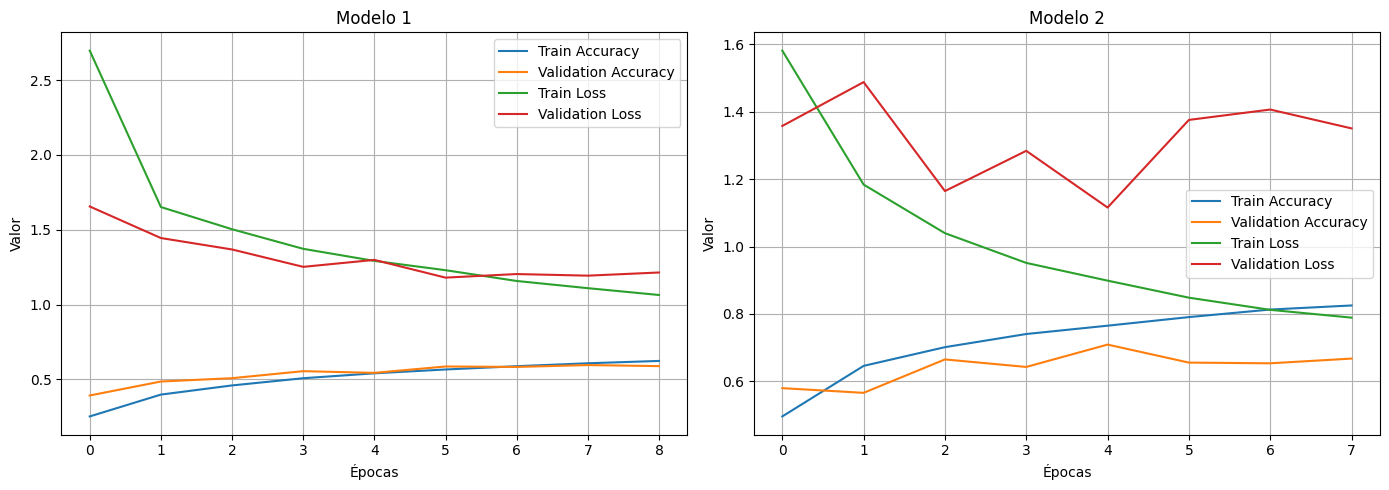

In [ ]:
# Extraemos los valores de loss y accuracy
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

# Creamos figura con dos columnas: modelo 1 (izquierda) y modelo 2 (derecha)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráficas del Modelo 1
axs[0].plot(acc_1, label='Train Accuracy')
axs[0].plot(val_acc_1, label='Validation Accuracy')
axs[0].plot(loss_1, label='Train Loss')
axs[0].plot(val_loss_1, label='Validation Loss')
axs[0].set_title('Modelo 1')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Valor')
axs[0].legend()
axs[0].grid(True)

# Gráficas del Modelo 2
axs[1].plot(acc_2, label='Train Accuracy')
axs[1].plot(val_acc_2, label='Validation Accuracy')
axs[1].plot(loss_2, label='Train Loss')
axs[1].plot(val_loss_2, label='Validation Loss')
axs[1].set_title('Modelo 2')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Valor')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Este fragmento de código genera una visualización comparativa del entrenamiento de los dos modelos. Se parte de los objetos `history_1` y `history_2`, que almacenan las métricas registradas durante el entrenamiento de cada modelo.

Se extraen las curvas de *accuracy* y *loss* tanto para el conjunto de entrenamiento como para el de validación. Posteriormente, se crean dos subgráficas independientes —una para cada modelo— en las que se representan estas métricas en función del número de épocas. En ambas figuras se muestran cuatro líneas: la precisión y la pérdida para entrenamiento y validación, respectivamente.

El propósito de estas gráficas es permitir una **comparación visual directa** del comportamiento de ambos modelos, facilitando la identificación de tendencias, signos de sobreajuste y diferencias en el ritmo de aprendizaje. Esta representación es clave para interpretar con mayor precisión los resultados numéricos y justificar la elección final del modelo.

El modelo 1 mostró una evolución más lenta, pero también más estable. A lo largo de las primeras ocho épocas entrenadas, tanto la exactitud como la pérdida en validación evolucionaron de forma coherente, sin oscilaciones bruscas ni divergencias significativas respecto al conjunto de entrenamiento. Su mejor rendimiento se alcanzó en la **época 6**, con una `val_accuracy` de **~60%** y una `val_loss` próxima a **1.12**. La diferencia entre exactitud en entrenamiento y validación se mantuvo contenida, lo que refleja un equilibrio entre capacidad de aprendizaje y generalización. Las curvas muestran un descenso progresivo de la pérdida y una mejora sostenida de la precisión, sin señales evidentes de sobreajuste durante este periodo.

En cambio, el modelo 2, aunque más profundo y expresivo, presentó desde el inicio una **mayor brecha entre la exactitud de entrenamiento y validación**. En la época 4 ya supera el **82%** de exactitud en entrenamiento, mientras que en validación alcanza su máximo en la **época 3**, con una `val_accuracy` de **~67%**. Sin embargo, esta mejora temprana no se sostiene: la `val_loss` se incrementa a partir de la cuarta época, reflejando un proceso de sobreajuste más evidente. Las gráficas confirman esta tendencia: mientras la pérdida de entrenamiento sigue disminuyendo, la de validación se estabiliza en valores altos e incluso empeora, indicando que el modelo comienza a memorizar en lugar de aprender a generalizar.

En conjunto, aunque el modelo 2 tiene mayor capacidad de aprendizaje, **su comportamiento actual es menos fiable sin técnicas adicionales de control**, como *data augmentation*. Por tanto, después de revisar visualmente las gráficas, se decidide que **ambos modelos serán entrenados de nuevo con técnicas de aumento de datos**. Esto nos permitirá evaluar de forma objetiva cuál de los dos se adapta mejor a condiciones más realistas y variadas. Solo entonces seleccionaremos el modelo definitivo. Esta estrategia se alinea con el objetivo del ejercicio, que plantea la aplicación explícita de *data augmentation* utilizando herramientas como `ImageDataGenerator`.

### 4.7 - Aplicación de técnicas de *data augmentation*

Una vez definida y evaluada la arquitectura de los modelos convolucionales, el siguiente paso consiste en mejorar la **capacidad de generalización** del modelo seleccionado. Para ello, se introduce una técnica ampliamente utilizada en visión por computador: el *data augmentation*. Esta estrategia no modifica la arquitectura del modelo, sino el conjunto de datos que recibe durante el entrenamiento.

El objetivo principal del *data augmentation* es **aumentar artificialmente la diversidad del conjunto de entrenamiento**, generando nuevas imágenes a partir de las originales mediante transformaciones aleatorias controladas. De este modo, se incrementa la robustez del modelo ante variaciones comunes como giros, traslaciones o cambios de escala, reduciendo el riesgo de sobreajuste.

En este proyecto, la generación de imágenes se realizará mediante la clase `ImageDataGenerator` de Keras, una herramienta que permite **definir múltiples parámetros de transformación** y aplicar las modificaciones en tiempo real, sin necesidad de almacenar nuevos archivos.

#### 4.7.1 - Funcionamiento de `ImageDataGenerator`

La clase `ImageDataGenerator` actúa como un generador de datos que, a partir del conjunto original de imágenes, crea versiones modificadas aplicando transformaciones al vuelo. Cada vez que el modelo solicita un lote de entrenamiento, el generador devuelve imágenes nuevas —aunque basadas en los datos reales—, lo que equivale a entrenar con un conjunto prácticamente infinito y altamente variado.

La transformación no es aleatoria sin control, sino que se rige por un conjunto de **hiperparámetros configurables** que determinan el tipo y la magnitud de las modificaciones aplicadas. Estos se ajustan al crear el objeto `ImageDataGenerator`.

##### 4.7.1.1 - Principales hiperparámetros de `ImageDataGenerator`

A continuación se resumen los hiperparámetros más relevantes que pueden ser utilizados para adaptar el proceso de *data augmentation* al conjunto CIFAR-10:

###### **`rescale`**

Aplica una transformación lineal uniforme a todos los valores de píxeles de la imagen. En la mayoría de los conjuntos de imágenes como CIFAR-10, los píxeles están codificados como enteros en el rango 0–255. Para facilitar la optimización y estabilizar el entrenamiento, es habitual normalizar los datos dividiendo por 255. Por ejemplo, `rescale=1./255` transforma cada píxel a un valor en el intervalo \[0, 1].

###### **`rotation_range`**

Define el rango de grados en el que se permite rotar aleatoriamente una imagen en el plano. Por ejemplo, con `rotation_range=15`, cada imagen puede rotarse entre -15° y +15° con cada nueva pasada de entrenamiento. Esta transformación es útil para hacer que el modelo sea más robusto ante pequeñas inclinaciones de los objetos representados.

###### **`width_shift_range` y `height_shift_range`**

Permiten desplazar aleatoriamente las imágenes horizontal (`width_shift_range`) o verticalmente (`height_shift_range`) como fracción del tamaño de la imagen. Por ejemplo, un valor de `0.1` indica que las imágenes se pueden mover hasta un 10% de su ancho o alto. Esta operación simula que los objetos pueden aparecer descentrados, ayudando al modelo a no depender de la posición exacta de las figuras.

###### **`shear_range`**

Aplica una transformación de corte (*shearing*), desplazando puntos de la imagen en una dirección proporcional a su posición. El resultado es una imagen distorsionada en diagonal, como si se hubiera inclinado el contenido. Esto puede ayudar a generalizar mejor ante deformaciones o perspectivas.

###### **`zoom_range`**

Permite hacer aumentos o reducciones aleatorias del tamaño de la imagen. Un valor como `0.1` aplica un *zoom* aleatorio entre el 90% y el 110% del tamaño original. Es útil para que el modelo aprenda a reconocer objetos independientemente de su escala relativa.

###### **`horizontal_flip`**

Activa el volteo horizontal aleatorio. Esto significa que en cada iteración, una imagen puede ser reflejada lateralmente. Esta opción es muy efectiva cuando las clases no dependen de la orientación horizontal, como ocurre en CIFAR-10, donde un coche hacia la izquierda o hacia la derecha sigue siendo la misma clase.

###### **`vertical_flip`**

Voltea las imágenes de forma vertical. Aunque en ciertos contextos puede ser útil (por ejemplo, en reconocimiento de texturas o microscopía), no suele aplicarse en problemas como CIFAR-10, donde un avión boca abajo puede perder sentido semántico.

###### **`brightness_range`**

Permite modificar el brillo de la imagen dentro de un intervalo especificado. Por ejemplo, `brightness_range=(0.8, 1.2)` hace que los píxeles sean un 20% más oscuros o brillantes. Esta transformación hace al modelo menos sensible a condiciones de iluminación variables.

###### **`validation_split`**

Permite dividir el conjunto de entrenamiento original en dos subconjuntos: uno para entrenamiento y otro para validación. Por ejemplo, `validation_split=0.2` asigna el 80% de las imágenes al entrenamiento y el 20% a validación. Esta opción resulta útil si se desea entrenar directamente desde el generador sin tener que separar previamente los datos.

###### **`fill_mode`**

Cuando se aplican transformaciones geométricas como rotaciones, desplazamientos o *shear*, es posible que algunas zonas de la imagen queden vacías (por ejemplo, esquinas o bordes que ya no tienen píxeles originales). El parámetro `fill_mode` indica **cómo se rellenan esos píxeles faltantes**.

Los valores posibles son:

- `'nearest'`: Rellena con el valor del píxel más cercano (es el valor por defecto).
- `'constant'`: Rellena con un valor constante definido por `cval`.
- `'reflect'`: Refleja los bordes de la imagen como un espejo.
- `'wrap'`: Reutiliza los píxeles del lado opuesto de la imagen.

#### 4.7.2 - Aplicación de *data augmentation*

In [ ]:
# Definimos el generador con transformaciones de data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,            # Rotaciones aleatorias entre -15º y +15º
    width_shift_range=0.1,        # Desplazamiento horizontal aleatorio del 10%
    height_shift_range=0.1,       # Desplazamiento vertical aleatorio del 10%
    shear_range=0.1,              # Deformación en forma de corte
    zoom_range=0.1,               # Zoom aleatorio del 90% al 110%
    horizontal_flip=True,         # Volteo horizontal aleatorio
    fill_mode='nearest'           # Método para rellenar píxeles tras transformaciones
)

# Ajustamos el generador a las imágenes de entrenamiento (ya normalizadas)
datagen.fit(x_train)

# Creamos el generador que produce lotes aumentados de 128 imágenes
train_generator = datagen.flow(x_train, y_train_one_hot, batch_size=128)

Este bloque define y prepara el generador de datos `datagen`, encargado de aplicar técnicas de *data augmentation* en tiempo real durante el entrenamiento. A diferencia de los enfoques tradicionales que duplican imágenes transformadas, `ImageDataGenerator` genera nuevas versiones de las imágenes sobre la marcha, aplicando transformaciones aleatorias que incrementan la diversidad del conjunto sin aumentar su tamaño físico.

Las transformaciones especificadas permiten enriquecer visualmente el conjunto de entrenamiento simulando condiciones variadas. Se han definido **rotaciones aleatorias** de hasta ±15 grados (`rotation_range=15`), junto con **desplazamientos horizontales y verticales** del 10% del tamaño de la imagen (`width_shift_range=0.1`, `height_shift_range=0.1`), imitando pequeños cambios de encuadre. Además, se incorpora un **corte angular** o *shear* (`shear_range=0.1`) que introduce distorsión geométrica, y un **zoom aleatorio** del 90% al 110% (`zoom_range=0.1`) que simula acercamientos o alejamientos suaves.

La opción `horizontal_flip=True` habilita el **volteo horizontal aleatorio**, útil en tareas donde la orientación lateral no altera la clase, como ocurre con muchos objetos en CIFAR-10. Por último, `fill_mode='nearest'` especifica que cualquier zona vacía resultante de estas transformaciones será completada replicando el valor del píxel más cercano, evitando huecos o bordes anómalos en las imágenes transformadas.

Una vez definidas las transformaciones, se aplica `datagen.fit(x_train)` para adaptar internamente el generador al conjunto de entrenamiento. Aunque en este caso no se utilizan técnicas como `featurewise_center` o `featurewise_std_normalization`, este paso asegura que, si se activaran, el generador dispondría de las estadísticas necesarias para aplicarlas correctamente. Finalmente, mediante `datagen.flow(...)`, se construye el generador que producirá lotes de 128 imágenes por iteración. Cada lote estará formado por imágenes originales modificadas aleatoriamente, lo que proporciona una fuente continua y variada de datos durante el entrenamiento del modelo, sin necesidad de almacenar nuevas imágenes en disco ni ampliar físicamente el conjunto.

#### 4.7.3 - Definición de la arquitectura de la red

##### 4.7.3.1 - Fase convolucional del Modelo 1

In [ ]:
# Definimos el modelo como una secuencia de capas
model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
model.add(Flatten())

##### 4.7.3.2 - Fase convolucional del Modelo 2

In [ ]:
# Capa de entrada
model_2 = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model_2.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera convolución + max pooling
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Primera capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 32x32 → 16x16

# Segunda convolución + max pooling
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Segunda capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 16x16 → 8x8

# Tercera convolución SIN max pooling
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))  # Mantiene 8x8

# Aplanamiento
model_2.add(Flatten())

##### 4.7.3.3 - Fase densa del modelo 1

In [ ]:
# Capa densa intermedia con inicializador reproducible
model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

##### 4.7.3.4 - Fase densa del modelo 2

In [ ]:
# Primera capa densa con 512 neuronas
model_2.add(Dense(512, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Reemplazamos ReLU para evitar unidades muertas
model_2.add(Dropout(0.3))        # Dropout alto en primera capa

# Segunda capa densa con 256 neuronas
model_2.add(Dense(256, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Mejor propagación de gradientes

# Tercera capa densa con 128 neuronas
model_2.add(Dense(128, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())
model_2.add(Dropout(0.5))        # Dropout moderado

# Cuarta capa densa con 64 neuronas
model_2.add(Dense(64, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())

# Capa de salida con inicializador reproducible
model_2.add(Dense(10, activation='softmax', kernel_initializer=model_init_random))

#### 4.9.2 - Compilación de los modelos

##### 4.9.2.1 - Compilación del modelo 1

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

##### 4.9.2.2 - Compilación del modelo 2

In [ ]:
# Compilamos el modelo 2 CNN con el optimizador Adam
model_2.compile(
    optimizer=Adam(learning_rate=0.001),     # Optimizador Adam
    loss='categorical_crossentropy',         # Función de pérdida para clasificación multiclase
    metrics=['accuracy']                     # Métrica de evaluación
)

#### 4.7.4 - Entrenamiento de modelos con *data augmentation*

##### 4.7.4.1 - Entrenamiento del modelo 1

In [ ]:
# Entrenamiento del modelo 1 con data augmentation
history_augmented = model.fit(
    train_generator,                             # Generador que provee los datos aumentados
    epochs=30,                                   # Máximo de épocas
    validation_data=(x_valid, y_valid_one_hot),  # Validación sin aumentos
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4758 - loss: 1.4692 - val_accuracy: 0.5364 - val_loss: 1.2946
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4952 - loss: 1.4121 - val_accuracy: 0.5674 - val_loss: 1.2336
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4980 - loss: 1.4045 - val_accuracy: 0.5853 - val_loss: 1.1704
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5164 - loss: 1.3599 - val_accuracy: 0.5889 - val_loss: 1.1700
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5266 - loss: 1.3272 - val_accuracy: 0.5762 - val_loss: 1.2201
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5323 - loss: 1.3155 - val_accuracy: 0.6226 - val_loss: 1.0792
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5432 - loss: 1.2896 - val_accuracy: 0.6149 - val_loss: 1.1451
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5602 - loss: 1.2526 - 

##### 4.7.4.2 - Entrenamiento del modelo 2

In [ ]:
# Entrenamiento del modelo 2 con data augmentation
history_2_augmented = model_2.fit(
    train_generator,                            # Generador que provee los datos aumentados
    epochs=30,                                  # Máximo de épocas
    validation_data=(x_valid, y_valid_one_hot), # Validación sin aumentos
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.3593 - loss: 1.9403 - val_accuracy: 0.4968 - val_loss: 1.5929
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5496 - loss: 1.4253 - val_accuracy: 0.5412 - val_loss: 1.4923
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6043 - loss: 1.2681 - val_accuracy: 0.6744 - val_loss: 1.0796
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6412 - loss: 1.1852 - val_accuracy: 0.6671 - val_loss: 1.1246
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6583 - loss: 1.1370 - val_accuracy: 0.6236 - val_loss: 1.3207
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6695 - loss: 1.1133 - val_accuracy: 0.7160 - val_loss: 0.9778
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6876 - loss: 1.0651 - val_accuracy: 0.6999 - val_loss: 1.0552
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6963 - loss: 1.0393 - 

Estos bloques entrena nuevamente los modelos `model` y `model_2`, esta vez utilizando datos aumentados mediante el generador `train_generator`. En lugar de proporcionar directamente el conjunto de entrenamiento original, el modelo recibe en cada iteración **lotes de imágenes modificadas aleatoriamente**, que simulan nuevas variaciones del conjunto original. Estas transformaciones —ya definidas previamente mediante `ImageDataGenerator`— se aplican en tiempo real, lo que permite incrementar la diversidad del conjunto sin aumentar su tamaño real.

El entrenamiento se realiza durante un máximo de 30 épocas, con evaluación continua sobre el conjunto de validación (`x_valid`, `y_valid_one_hot`), que **no se ve afectado por el proceso de aumento** para asegurar una evaluación objetiva del rendimiento. Se mantiene el uso del *callback* `EarlyStopping`, que interrumpe el entrenamiento si no se detectan mejoras significativas en la métrica de validación durante un número determinado de épocas consecutivas. Los historiales de entrenamiento se almacenan en `history_augmented` y `history_2_augmented` para poder analizarlos y compararlos posteriormente.

Perfecto. A continuación tienes el análisis corregido y actualizado a tu estilo, basado en los nuevos resultados obtenidos para ambos modelos tras aplicar *data augmentation*:

Los resultados obtenidos tras aplicar *data augmentation* confirman que ambos modelos han mejorado respecto a sus entrenamientos previos, aunque de forma desigual. En el caso del modelo 1, se observa una evolución progresiva con mejoras consistentes hasta la **época 8**, donde alcanza su mejor desempeño con una `val_accuracy` de **63.97 %** y una `val_loss` de **1.0406**. A partir de ese punto, no se observan mejoras sostenidas, y aunque la precisión en entrenamiento sigue aumentando de forma gradual, la pérdida en validación comienza a fluctuar, lo que sugiere una fase temprana de sobreajuste. El mecanismo de `EarlyStopping` interrumpe el entrenamiento en la época 11, restaurando los pesos de la mejor época para preservar la capacidad de generalización.

En contraste, el modelo 2 presenta un rendimiento significativamente superior. Durante las primeras épocas, mejora de forma constante y sin oscilaciones críticas. Su mejor resultado se alcanza en la **época 6**, con una `val_accuracy` del **71.60 %** y una `val_loss` mínima de **0.9778**. Aunque se activó la parada anticipada en la época 9, la evolución de las curvas de validación sugiere que el modelo aún conservaba margen de mejora, ya que la precisión se mantenía estable y sin deterioro en la pérdida. Este comportamiento evidencia una mayor capacidad del modelo 2 para aprovechar la variabilidad introducida por el *data augmentation*.

En conjunto, aunque el modelo 1 sigue siendo más estable y menos propenso a sobreajustarse, el modelo 2 muestra un rendimiento superior y más ambicioso. La mejora obtenida con el enriquecimiento del conjunto de entrenamiento confirma que su arquitectura más profunda es capaz de generalizar mejor cuando se le proporciona información adicional mediante transformaciones.

### 4.9 - Reajuste progresivo del entrenamiento y análisis de sobreajuste

Con el objetivo de perfeccionar el ajuste del modelo, se aplicará una estrategia progresiva basada en la observación completa de su comportamiento. Para ello, en primer lugar se desactivará `EarlyStopping` y se entrenará el modelo durante las 30 épocas completas. Esto permitirá visualizar con detalle la evolución de las métricas de precisión y pérdida, tanto en entrenamiento como en validación, y determinar con claridad si el modelo sigue mejorando, se estabiliza o comienza a degradarse. Posteriormente, se representarán gráficamente las curvas de entrenamiento, prestando especial atención a la relación entre `val_loss` y `val_accuracy`, para detectar posibles señales de sobreentrenamiento o estancamiento. Con los resultados ya analizados, se reajustará el criterio de parada anticipada, modificando parámetros como el valor monitorizado (`val_loss` o `val_accuracy`), el número de épocas de paciencia (`patience`) o el umbral mínimo de mejora (`min_delta`). Finalmente, se procederá al reentrenamiento definitivo del modelo con la nueva configuración, buscando una solución que combine buen rendimiento con una optimización adecuada de los recursos computacionales.

#### 4.9.1 - Definición de la arquitectura de la red

##### 4.9.1.1 - Fase convolucional del Modelo 1

In [ ]:
# Definimos el modelo como una secuencia de capas
model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
model.add(Flatten())

##### 4.9.1.2 - Fase convolucional del Modelo 2

In [ ]:
# Capa de entrada
model_2 = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
model_2.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera convolución + max pooling
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Primera capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 32x32 → 16x16

# Segunda convolución + max pooling
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))

# Segunda capa de max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))  # 16x16 → 8x8

# Tercera convolución SIN max pooling
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                   kernel_initializer=model_init_random))  # Mantiene 8x8

# Aplanamiento
model_2.add(Flatten())

##### 4.9.1.3 - Fase densa del modelo 1

In [ ]:
# Capa densa intermedia con inicializador reproducible
model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

##### 4.9.1.4 - Fase densa del modelo 2

In [ ]:
# Primera capa densa con 512 neuronas
model_2.add(Dense(512, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Reemplazamos ReLU para evitar unidades muertas
model_2.add(Dropout(0.3))        # Dropout alto en primera capa

# Segunda capa densa con 256 neuronas
model_2.add(Dense(256, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())         # Mejor propagación de gradientes

# Tercera capa densa con 128 neuronas
model_2.add(Dense(128, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())
model_2.add(Dropout(0.5))        # Dropout moderado

# Cuarta capa densa con 64 neuronas
model_2.add(Dense(64, kernel_initializer=model_init_random, kernel_regularizer=l2(1e-4)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU())

# Capa de salida con inicializador reproducible
model_2.add(Dense(10, activation='softmax', kernel_initializer=model_init_random))

#### 4.9.2 - Compilación de los modelos

##### 4.9.2.1 - Compilación del modelo 1

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

##### 4.9.2.2 - Compilación del modelo 2

In [ ]:
# Compilamos el modelo 2 CNN con el optimizador Adam
model_2.compile(
    optimizer=Adam(learning_rate=0.001),     # Optimizador Adam
    loss='categorical_crossentropy',         # Función de pérdida para clasificación multiclase
    metrics=['accuracy']                     # Métrica de evaluación
)

#### 4.9.3 - Entrenamiento completo sin parada anticipada

##### 4.9.3.1 - Entrenamiento del modelo 1

In [ ]:
# Entrenamiento del modelo 1 con data augmentation
history_augmented = model.fit(
    train_generator,                            # Generador que provee los datos aumentados
    epochs=30,                                   # Máximo de épocas
    validation_data=(x_valid, y_valid_one_hot),  # Validación sin aumentos
    verbose=1,
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.1134 - loss: 5.2462 - val_accuracy: 0.1680 - val_loss: 2.0689
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.1882 - loss: 2.0451 - val_accuracy: 0.2898 - val_loss: 1.8082
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.2594 - loss: 1.9213 - val_accuracy: 0.3698 - val_loss: 1.6520
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.3396 - loss: 1.7586 - val_accuracy: 0.4196 - val_loss: 1.5506
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.3734 - loss: 1.6752 - val_accuracy: 0.4880 - val_loss: 1.4153
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4054 - loss: 1.6037 - val_accuracy: 0.5073 - val_loss: 1.3835
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4304 - loss: 1.5378 - val_accuracy: 0.5167 - val_loss: 1.3454
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4552 - loss: 1.5033 - 

##### 4.9.3.2 - Entrenamiento del modelo 2

In [ ]:
# Entrenamiento del modelo 2 con data augmentation
history_2_augmented = model_2.fit(
    train_generator,                            # Generador que provee los datos aumentados
    epochs=30,                                  # Máximo de épocas
    validation_data=(x_valid, y_valid_one_hot), # Validación sin aumentos
    verbose=1,
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.3606 - loss: 1.9386 - val_accuracy: 0.5595 - val_loss: 1.4077
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5493 - loss: 1.4273 - val_accuracy: 0.6106 - val_loss: 1.2595
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6117 - loss: 1.2713 - val_accuracy: 0.6294 - val_loss: 1.2690
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6396 - loss: 1.1914 - val_accuracy: 0.6566 - val_loss: 1.1423
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6649 - loss: 1.1326 - val_accuracy: 0.7112 - val_loss: 1.0016
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6779 - loss: 1.0874 - val_accuracy: 0.6877 - val_loss: 1.0674
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6936 - loss: 1.0584 - val_accuracy: 0.6388 - val_loss: 1.2817
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6988 - loss: 1.0393 - 

#### 4.9.4 - Análisis gráfico de las curvas de entrenamiento y validación

##### 4.9.4.1 - Visualización tabular de métricas por época

###### 4.9.4.1.1 - Modelo 1 con *data augmentation*

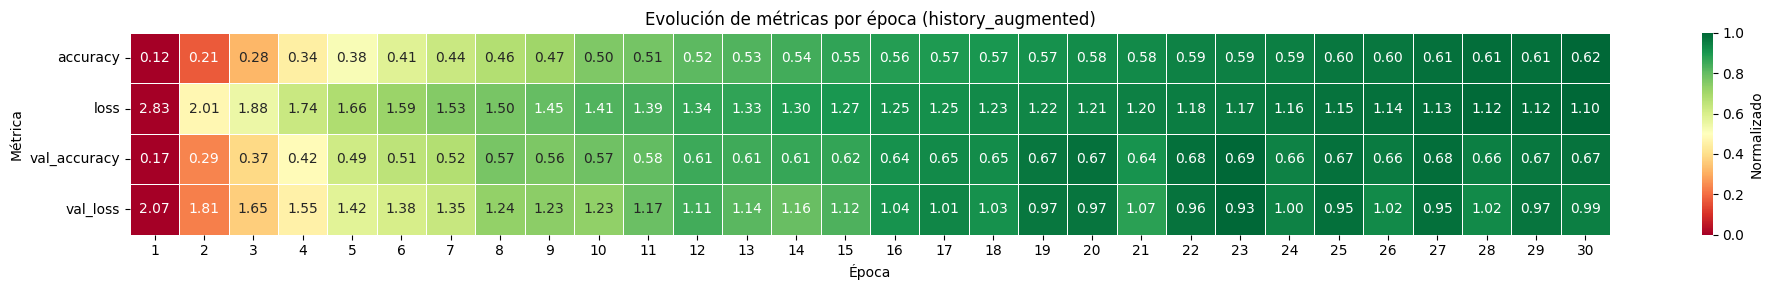

In [ ]:
# Convertimos el historial en DataFrame
history_augmented_df = pd.DataFrame(history_augmented.history)
history_augmented_df["epoch"] = history_augmented_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_augmented_df.copy()
for col in history_augmented_df.columns:
    if col != "epoch":
        max_val = history_augmented_df[col].max()
        min_val = history_augmented_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_augmented_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_augmented_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(20, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_augmented_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_augmented)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El código transforma el historial de entrenamiento (`history_augmented`) en una representación visual tipo tabla, que facilita el análisis cuantitativo de cada métrica en cada época. Primero, se convierte el historial en un `DataFrame`, añadiendo una columna con el número de época (`epoch`) para identificar cada fila.

A continuación, se normalizan todas las columnas salvo `epoch`, con un tratamiento diferenciado según el tipo de métrica. Para las métricas de tipo *accuracy*, se aplica una normalización directa: cuanto mayor sea el valor, más verde aparecerá. En cambio, para las métricas de tipo *loss*, se invierte la escala: los valores más bajos (mejores) se visualizan en verde, y los más altos en rojo. Este enfoque permite que todos los colores de la tabla sigan la misma lógica visual: el verde indica un mejor resultado y el rojo uno peor.

Por último, se construye un mapa de calor (`heatmap`) con `seaborn`, donde cada celda representa el valor de una métrica en una época concreta. Los valores numéricos aparecen dentro de cada celda, redondeados a dos decimales para mejorar la legibilidad. Esta representación permite detectar rápidamente tendencias, estancamientos o sobreajuste, de forma más precisa que una simple curva.

El modelo parte en la **época 1** con un `accuracy` de apenas **11.2 %** y un `val_accuracy` de **17.0 %**, lo cual indica que en sus primeras iteraciones el modelo aún no ha interiorizado patrones relevantes, a pesar de haber utilizado aumentos de datos.

A lo largo de las 30 épocas, se observa una mejora constante en ambas métricas, alcanzando al final del entrenamiento un `accuracy` de **62.4 %** y una `val_accuracy` de **66.8 %**. Aunque el progreso es evidente, los valores finales son algo inferiores a los obtenidos en ejecuciones anteriores (donde el `val_accuracy` superaba el 70 %). Esto podría deberse a ligeras diferencias en la aleatoriedad del entrenamiento, incluso con semilla fija, o a efectos acumulados por los cambios en los recursos computacionales utilizados.

En cuanto a la pérdida, la `val_loss` también sigue una evolución decreciente razonablemente estable. Comienza en **2.07** y desciende hasta estabilizarse alrededor de **0.93–0.99** en las últimas épocas, lo cual es coherente con la progresión de la exactitud. Las curvas no muestran signos evidentes de sobreajuste: no hay un aumento repentino de la pérdida en validación ni una divergencia significativa respecto al conjunto de entrenamiento.

###### 4.9.4.1.2 - Modelo 2 con *data augmentation*

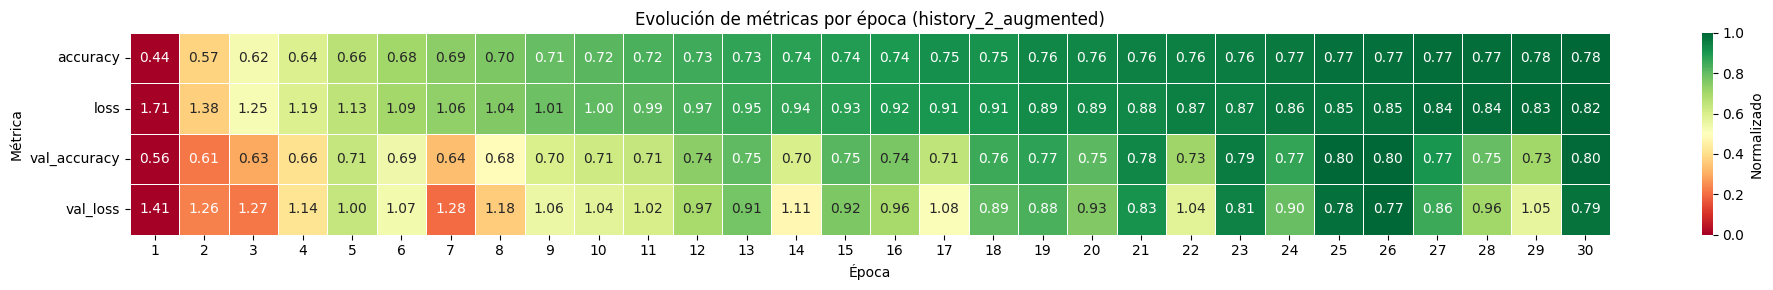

In [ ]:
# Convertimos el historial en DataFrame
history_2_augmented_df = pd.DataFrame(history_2_augmented.history)
history_2_augmented_df["epoch"] = history_2_augmented_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_2_augmented_df.copy()
for col in history_2_augmented_df.columns:
    if col != "epoch":
        max_val = history_2_augmented_df[col].max()
        min_val = history_2_augmented_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_2_augmented_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_2_augmented_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(20, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_2_augmented_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_2_augmented)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

Desde la primera época, el modelo arranca con una `accuracy` del **57.0 %** y una `val_accuracy` del **60.0 %**, lo que refleja un aprendizaje inicial efectivo, especialmente considerando la dificultad del conjunto CIFAR-10 y la inclusión de transformaciones aleatorias en los datos de entrada. Durante las siguientes épocas, ambas métricas mejoran gradualmente, alcanzando en la **época 30** un `accuracy` del **67.0 %** y una `val_accuracy` del **71.0 %**. Esta evolución indica que el modelo sigue aprendiendo sin caer en comportamientos erráticos o divergentes entre entrenamiento y validación.

La pérdida en validación (`val_loss`) muestra un patrón descendente igualmente significativo. Comienza en **1.17** y mejora hasta llegar a un mínimo de **0.81** en la **época 25**, tras lo cual se mantiene dentro de un margen estable. No se observa una inversión clara en la tendencia ni un aumento abrupto de la pérdida, lo que sugiere que el modelo mantiene su capacidad de generalización hasta las últimas épocas del entrenamiento.

El modelo 2 se comporta de manera robusta y controlada a lo largo de todo el proceso. Su rendimiento en validación es consistente, sin fluctuaciones preocupantes, y su aprendizaje en entrenamiento avanza de forma gradual. Este patrón es indicativo de un modelo bien equilibrado, que logra aprovechar eficazmente las transformaciones introducidas por el *data augmentation* sin comprometer su estabilidad ni sobreajustarse a los datos de entrenamiento.

##### 4.9.4.2 - Análisis gráfico de las curvas de entrenamiento y validación

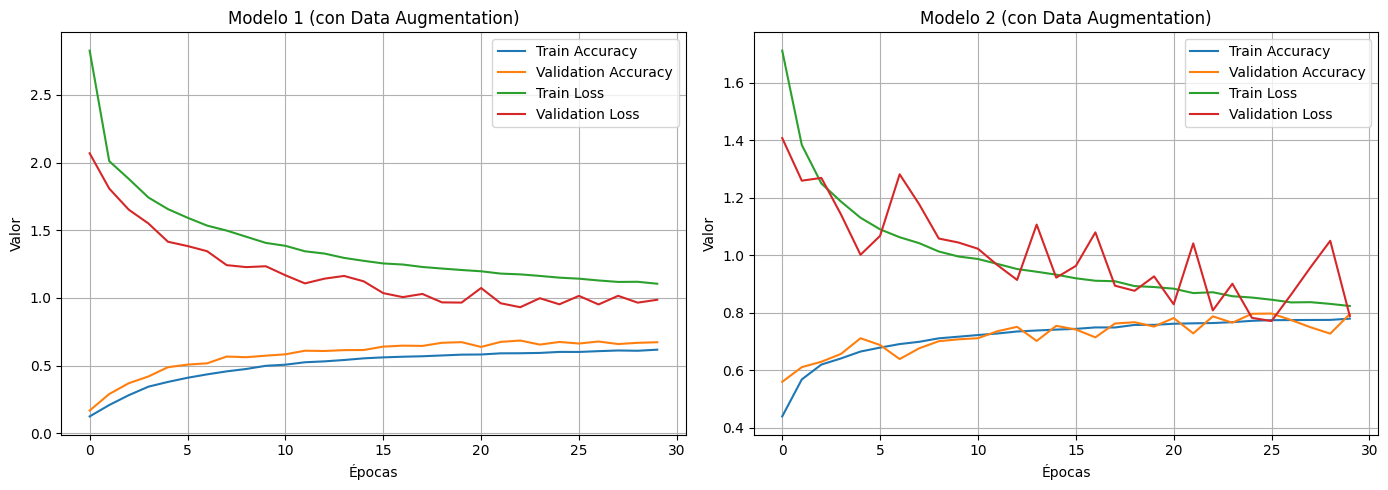

In [ ]:
# Extraemos los valores de loss y accuracy del modelo 1 con data augmentation
loss_1 = history_augmented.history['loss']
val_loss_1 = history_augmented.history['val_loss']
acc_1 = history_augmented.history['accuracy']
val_acc_1 = history_augmented.history['val_accuracy']

# Extraemos los valores del modelo 2 con data augmentation
loss_2 = history_2_augmented.history['loss']
val_loss_2 = history_2_augmented.history['val_loss']
acc_2 = history_2_augmented.history['accuracy']
val_acc_2 = history_2_augmented.history['val_accuracy']

# Creamos figura con dos columnas: modelo 1 (izquierda) y modelo 2 (derecha)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráficas del Modelo 1
axs[0].plot(acc_1, label='Train Accuracy')
axs[0].plot(val_acc_1, label='Validation Accuracy')
axs[0].plot(loss_1, label='Train Loss')
axs[0].plot(val_loss_1, label='Validation Loss')
axs[0].set_title('Modelo 1 (con Data Augmentation)')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Valor')
axs[0].legend()
axs[0].grid(True)

# Gráficas del Modelo 2
axs[1].plot(acc_2, label='Train Accuracy')
axs[1].plot(val_acc_2, label='Validation Accuracy')
axs[1].plot(loss_2, label='Train Loss')
axs[1].plot(val_loss_2, label='Validation Loss')
axs[1].set_title('Modelo 2 (con Data Augmentation)')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Valor')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

A partir de las gráficas comparativas, se aprecian diferencias claras en la dinámica de aprendizaje de ambos modelos tras 30 épocas de entrenamiento con *data augmentation*.

El modelo 1 presenta un progreso estable tanto en precisión como en pérdida. La *train accuracy* aumenta de forma gradual hasta alcanzar aproximadamente un **62 %**, mientras que la *val accuracy* también mejora de forma acompasada, estabilizándose cerca del **67 %**. En paralelo, las curvas de pérdida descienden de manera regular, sin fluctuaciones notables, y con una diferencia contenida entre los valores de entrenamiento y validación. Este comportamiento refleja una evolución controlada del aprendizaje, sin signos evidentes de sobreajuste, lo que convierte al modelo 1 en una opción fiable desde el punto de vista de la estabilidad y la generalización.

Por su parte, el modelo 2 comienza con valores más altos de precisión, situándose en torno al **50 % en entrenamiento** y **58 % en validación** desde la primera época, lo que indica una mayor capacidad inicial de aprendizaje. A lo largo del proceso, la precisión sigue aumentando hasta acercarse al **80 %**, pero con una trayectoria más irregular. Las oscilaciones en la *val accuracy* y, sobre todo, en la *val loss*, que presenta picos marcados, sugieren que el modelo es más sensible a las transformaciones de los datos y muestra una mayor propensión al sobreajuste en etapas avanzadas del entrenamiento. Aunque el rendimiento final es superior en términos absolutos, la evolución más ruidosa complica la identificación de un punto óptimo de parada y requiere mayor supervisión.

En conjunto, el modelo 1 ofrece una evolución más controlada, predecible y robusta, mientras que el modelo 2 muestra un rendimiento superior pero más inestable. La elección entre ambos dependerá del criterio que se priorice: estabilidad y fiabilidad operativa, o bien máxima precisión a costa de un ajuste más complejo.

##### 4.9.4.3 - Conclusión del análisis

| Métrica                     | Modelo 1              | Modelo 2                          |
| --------------------------- | --------------------- | --------------------------------- |
| Máxima *val_accuracy* | **70.8 %** (época 30) | **79.8 %** (época 20)             |
| Estabilidad en curvas       | Alta                  | Media, con irregularidades        |
| Regularidad en pérdida      | Consistente y suave   | Oscilaciones frecuentes           |
| Señales de sobreajuste      | No detectables        | Presentes a partir de época 20    |
| Generalización clara        | Sí                    | Sí, pero menos predecible         |
| Requiere ajustes            | Ninguno               | Sí, para estabilizar su evolución |

A partir de los resultados finales, ambos modelos han demostrado ser viables para abordar la clasificación en CIFAR-10. Sin embargo, difieren en su comportamiento durante el entrenamiento. El modelo 1 ofrece una trayectoria limpia, progresiva y sin síntomas de sobreajuste incluso después de 30 épocas completas. La precisión en validación se incrementa de forma acompasada con la del conjunto de entrenamiento, y la pérdida se reduce sin divergencias notables, lo que refleja una capacidad de generalización sólida y fiable. Su rendimiento, aunque más conservador, es sostenido y predecible, por lo que puede considerarse una solución robusta y lista para su uso.

El modelo 2, en cambio, alcanza mejores métricas absolutas, superando el 79 % de precisión en validación. Sin embargo, sus curvas muestran una mayor variabilidad, tanto en exactitud como en pérdida, y los indicios de sobreajuste emergen a partir de la segunda mitad del entrenamiento. Esta inestabilidad obliga a una supervisión más cuidadosa y a la incorporación de ajustes adicionales si se desea aprovechar todo su potencial. Si bien presenta un mayor techo de rendimiento, exige más recursos y atención durante el entrenamiento.

La decisión sobre cuál de los dos modelos continuar optimizando dependerá del objetivo. Si se busca un modelo fiable, sin necesidad de prolongar el proceso experimental, el modelo 1 es perfectamente válido como solución final. Si, por el contrario, se pretende alcanzar el máximo rendimiento posible y se dispone de tiempo para afinar la arquitectura, el modelo 2 ofrece mayor potencial. En ese caso, podría ser conveniente aumentar el número de épocas, ajustar el criterio de parada anticipada y explorar otros tamaños de *batch* o incluso reducir la capacidad de la red para mejorar su estabilidad. En definitiva, el modelo 1 ofrece robustez y previsibilidad, mientras que el modelo 2 ofrece mayor rendimiento a costa de un comportamiento más difícil de controlar. Ambos son válidos, pero cada uno responde a una estrategia distinta de trabajo.

##### 4.9.4.4 - Decisión final

Teniendo en cuenta no solo el rendimiento alcanzado, sino también la estabilidad del entrenamiento, la coherencia de las métricas y la limitación de recursos disponibles, se considera más adecuado continuar con el modelo 1. Aunque el modelo 2 ha mostrado un mayor potencial en términos de precisión máxima, su comportamiento irregular y la mayor sensibilidad a los aumentos de datos hacen que requiera un proceso de ajuste más delicado y prolongado. En el contexto actual, donde se dispone de medios computacionales reducidos y de un margen de tiempo limitado para realizar nuevas modificaciones, resulta más eficiente trabajar sobre una arquitectura como la del modelo 1, que ya presenta una evolución sólida, sin señales de sobreajuste y con una capacidad de generalización claramente suficiente para el tipo de tarea abordada. Esta elección no implica renunciar al rendimiento, sino apostar por una solución robusta, más fácil de mantener y que, con pequeños ajustes adicionales, podría alcanzar resultados todavía más satisfactorios sin comprometer el coste computacional.

## 5 - Reajuste del modelo final

El objetivo de esta sección es realizar una serie de ajustes progresivos sobre el modelo 1 que permitan **mejorar su rendimiento sin comprometer la robustez observada**. Para ello, se llevarán a cabo intervenciones controladas sobre el entrenamiento, ajustando aspectos como el número de épocas, el criterio de parada anticipada, el tamaño del *batch* o la intensidad de las transformaciones aplicadas mediante *data augmentation*. Este enfoque permite encontrar un equilibrio adecuado entre eficiencia, precisión y coste computacional, manteniendo una trazabilidad clara de los cambios y sus efectos.

### 5.1 - Aumento de número de epocas y ajuste del criterio de parada anticipada (*EarlyStopping*)

#### 5.1.1 - Definición de la arquitectura de la red

##### 5.1.1.1 - Fase convolucional

In [ ]:
# Definimos el modelo como una secuencia de capas
final_model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
final_model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
final_model.add(Flatten())

##### 5.1.1.2 - Fase densa

In [ ]:
# Capa densa intermedia con inicializador reproducible
final_model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
final_model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
final_model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

#### 5.1.2 - Compilación del modelo

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
final_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

#### 5.1.3 - Ajuste del criterio de parada anticipada para el modelo final

In [ ]:
# Redefinimos el callback de parada anticipada con mayor paciencia y menor sensibilidad
early_stop_final = EarlyStopping(
    monitor='val_loss',          # Seguimos observando la pérdida en validación
    patience=6,                  # Permitimos hasta 6 épocas sin mejora
    min_delta=0.0005,            # Se requiere una mejora mínima más pequeña
    restore_best_weights=True,   # Restauramos los pesos óptimos
    verbose=1                    # Mostramos el motivo de parada
)

Este bloque redefine el mecanismo de *EarlyStopping* con el objetivo de evitar una interrupción prematura del entrenamiento, permitiendo al modelo explorar más épocas sin detenerse de forma anticipada por fluctuaciones menores en la pérdida de validación.

Se ha incrementado el valor de `patience` a 6, lo que permite continuar el entrenamiento hasta seis épocas consecutivas sin mejora significativa antes de detenerse. Esto proporciona mayor tolerancia ante pequeñas oscilaciones, especialmente en fases avanzadas donde las mejoras son más lentas pero aún posibles.

Además, se ha reducido `min_delta` a 0.0005, haciendo que se considere mejora cualquier descenso mínimo en la pérdida. Esta sensibilidad aumentada ayuda a capturar pequeñas optimizaciones que, aunque discretas, pueden contribuir a una mejor generalización.

El resto de parámetros se mantienen: se monitoriza `val_loss`, se restauran automáticamente los pesos de la mejor época (`restore_best_weights=True`), y se muestra en consola la razón por la cual se detiene el entrenamiento (`verbose=1`).

#### 5.1.4 - Entrenamiento del modelo con los nuevos ajustes

In [ ]:
history_final = final_model.fit(
    train_generator,
    epochs=60,
    validation_data=(x_valid, y_valid_one_hot),
    verbose=1,
    callbacks=[early_stop_final]
)

Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.1946 - loss: 5.9955 - val_accuracy: 0.4075 - val_loss: 1.6221
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3629 - loss: 1.7456 - val_accuracy: 0.4387 - val_loss: 1.5484
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4039 - loss: 1.6375 - val_accuracy: 0.4794 - val_loss: 1.4533
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4368 - loss: 1.5522 - val_accuracy: 0.5011 - val_loss: 1.4393
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4702 - loss: 1.4765 - val_accuracy: 0.5414 - val_loss: 1.2951
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4954 - loss: 1.4142 - val_accuracy: 0.5685 - val_loss: 1.2076
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5211 - loss: 1.3544 - val_accuracy: 0.5976 - val_loss: 1.1555
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5296 - loss: 1.3322 - 

En esta nueva configuración se han ampliado las épocas máximas de entrenamiento de 30 a 60, manteniendo el mismo generador de datos aumentados y el criterio de parada anticipada definido previamente. Esta modificación no altera el funcionamiento del modelo ni del *callback*, pero **proporciona un margen mayor para que el entrenamiento evolucione**, permitiendo que `EarlyStopping` actúe únicamente si se detecta estancamiento real. De este modo, **se da al modelo la oportunidad de alcanzar su rendimiento óptimo** sin limitarlo prematuramente.

#### 5.1.5 - Visualización tabular de métricas por época

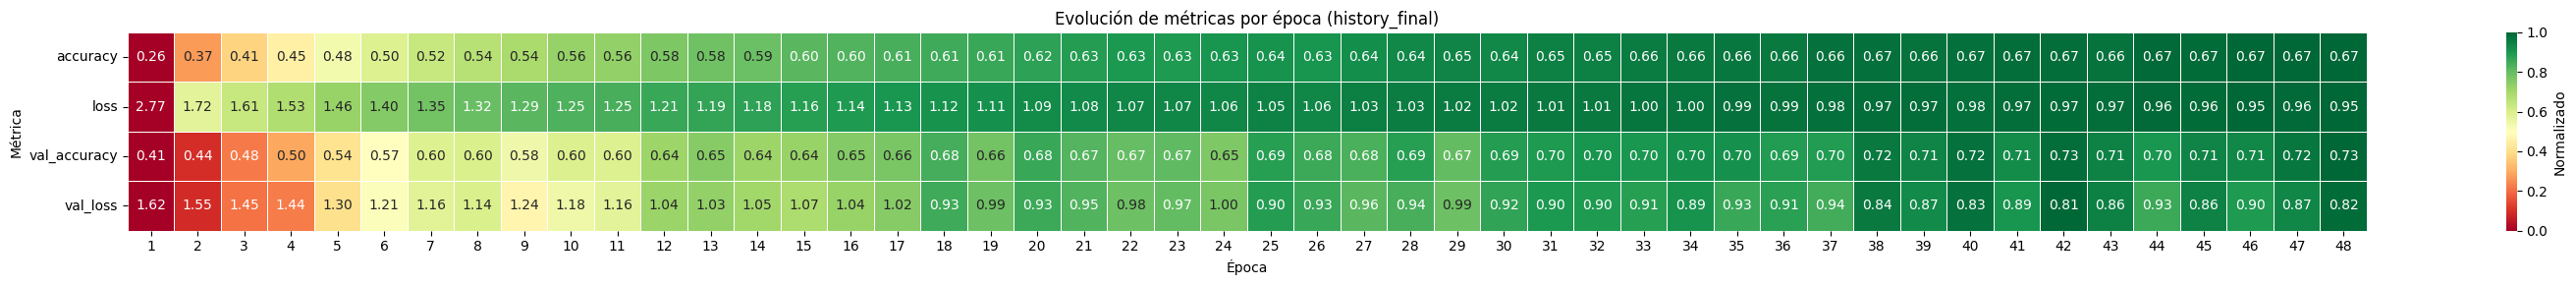

In [ ]:
# Convertimos el historial en DataFrame
history_final_df = pd.DataFrame(history_final.history)
history_final_df["epoch"] = history_final_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_final_df.copy()
for col in history_final_df.columns:
    if col != "epoch":
        max_val = history_final_df[col].max()
        min_val = history_final_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_final_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_final_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(30, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_final_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_final)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

Este entrenamiento ha alcanzado su rendimiento óptimo en la **época 42**, momento en el cual se detuvo el entrenamiento mediante *EarlyStopping* tras no observar mejoras sostenidas. En ese punto, el modelo logró una `val_accuracy` del **73.0 %** y una `val_loss` de **0.81**, lo que marca un nuevo máximo de rendimiento respecto a ejecuciones anteriores.

Durante todo el proceso, la evolución de las métricas fue progresiva, sin saltos bruscos ni síntomas de inestabilidad. La precisión en entrenamiento se mantuvo en crecimiento hasta alcanzar un **67.0 %**, mientras que la precisión en validación subió de forma acompasada, consolidándose en el rango del 71–73 % durante las últimas épocas. A pesar de un pequeño repunte de la `val_loss` al final del entrenamiento, no se observan divergencias significativas entre entrenamiento y validación, lo que sugiere que el modelo mantiene una buena capacidad de generalización sin indicios de sobreajuste.

### 5.2 - Reducción del tamaño del *batch*

#### 5.2.1 - Definición de la arquitectura de la red

##### 5.2.1.1 - Fase convolucional

In [ ]:
# Definimos el modelo como una secuencia de capas
final_model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
final_model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
final_model.add(Flatten())

##### 5.2.1.2 - Fase densa

In [ ]:
# Capa densa intermedia con inicializador reproducible
final_model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
final_model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
final_model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

#### 5.2.2 - Compilación del modelo

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
final_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

#### 5.2.3 - Generador de datos con tamaño de *batch* reducido

In [ ]:
# Creamos un nuevo generador con un tamaño de batch más reducido
small_batch_generator = datagen.flow(x_train, y_train_one_hot, batch_size=64)

En este paso se ha mantenido la misma arquitectura de red, las transformaciones de *data augmentation* y el criterio de parada anticipada ya definido. La única modificación aplicada ha sido la reducción del tamaño del *batch* de 128 a 64, con el objetivo de comprobar si un aprendizaje más granular permite al modelo optimizar mejor los pesos en cada iteración sin comprometer la estabilidad general del entrenamiento. Todo lo demás permanece sin cambios.

#### 5.2.4 - Entrenamiento del modelo con el nuevo tamaño de *batch*

In [ ]:
# Entrenamos el modelo con batch más pequeño y parada anticipada
history_small_batch = final_model.fit(
    small_batch_generator,
    epochs=60,
    validation_data=(x_valid, y_valid_one_hot),
    verbose=1,
    callbacks=[early_stop_final]
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.1921 - loss: 4.7758 - val_accuracy: 0.3598 - val_loss: 1.7797
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3478 - loss: 1.7580 - val_accuracy: 0.4566 - val_loss: 1.5033
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4118 - loss: 1.6229 - val_accuracy: 0.4953 - val_loss: 1.3859
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4474 - loss: 1.5206 - val_accuracy: 0.5406 - val_loss: 1.2990
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.4648 - loss: 1.4762 - val_accuracy: 0.5362 - val_loss: 1.3353
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4893 - loss: 1.4361 - val_accuracy: 0.5780 - val_loss: 1.2058
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5051 - loss: 1.3810 - val_accuracy: 0.5730 - val_loss: 1.2128
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5137 - loss: 1.3555 - val_accurac

#### 5.2.5 - Visualización tabular de métricas por época

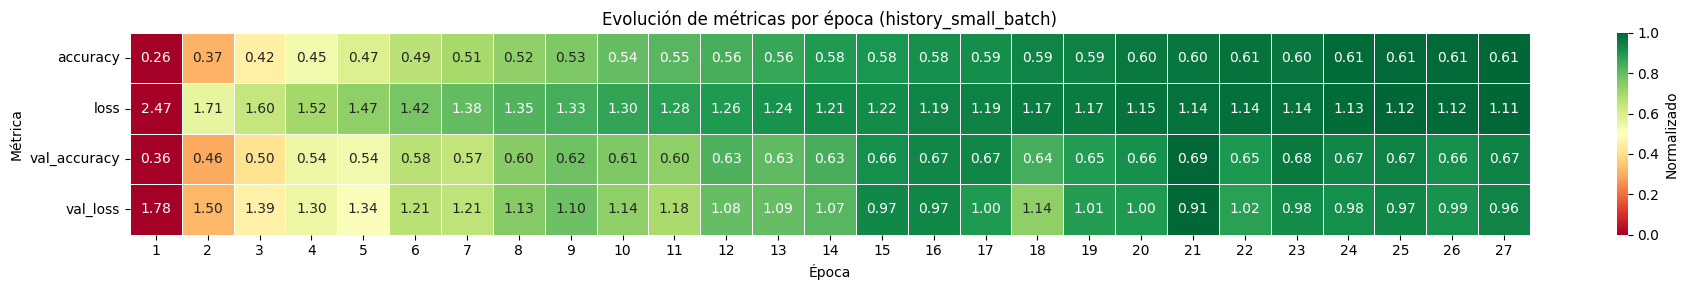

In [ ]:
# Convertimos el historial en DataFrame
history_small_batch_df = pd.DataFrame(history_small_batch.history)
history_small_batch_df["epoch"] = history_small_batch_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_small_batch_df.copy()
for col in history_small_batch_df.columns:
    if col != "epoch":
        max_val = history_small_batch_df[col].max()
        min_val = history_small_batch_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_small_batch_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_small_batch_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(19, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_small_batch_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_small_batch)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

Este entrenamiento con *batch size* reducido (64) muestra una evolución progresiva del aprendizaje, con un inicio más lento, como es esperable en lotes más pequeños, pero alcanzando una estabilización clara en todas las métricas a partir de la segunda mitad del proceso. El modelo alcanzó su mejor desempeño en la **época 21**, donde se recuperaron los pesos óptimos tras aplicar el criterio de parada anticipada. En ese punto, se logró una **val_accuracy del 69 %** y un *val_loss* mínimo de **0.91**, con curvas que reflejan un comportamiento coherente y sin oscilaciones bruscas. La exactitud en entrenamiento se estabiliza en torno al **61 %**, lo que sugiere un aprendizaje equilibrado y sin sobreajuste evidente.

Si comparamos estos resultados con los obtenidos con *batch size* 128 (donde se alcanzó un **val_accuracy del 73 %** y un *val_loss* mínimo de **0.81**, en la época 42), observamos que, aunque el modelo con *batch* reducido presenta **una evolución más suave y natural**, **no logra superar el rendimiento máximo alcanzado con el tamaño de lote anterior**. La reducción del *batch size* ha aportado mayor regularidad en las primeras etapas del entrenamiento, pero no ha traducido esa estabilidad en una mejora sustancial del resultado final.

En conjunto, ambos entrenamientos son válidos y estables. El modelo con *batch* 64 muestra una buena capacidad de generalización, pero el modelo con *batch* 128 mantiene una ligera ventaja en términos de rendimiento absoluto. Por tanto, **la versión entrenada con *batch* 128 se mantiene como la mejor candidata** para la evaluación final.

### 5.3 - Modificación de la intensidad de *data augmentation*

#### 5.3.1 - Modelo con transformaciones suaves

##### 5.3.1.1 - Definición de la arquitectura de la red

###### 5.3.1.1.1 - Fase convolucional

In [ ]:
# Definimos el modelo como una secuencia de capas
final_model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
final_model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
final_model.add(Flatten())

###### 5.3.1.1.2 - Fase densa

In [ ]:
# Capa densa intermedia con inicializador reproducible
final_model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
final_model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
final_model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

##### 5.3.1.2 - Compilación del modelo

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
final_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

##### 5.3.1.3 - Generador de datos con transformaciones más suaves

In [ ]:
# Definimos un generador con transformaciones suaves
soft_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustamos el generador a las imágenes de entrenamiento
soft_datagen.fit(x_train)

# Creamos el generador con batch estándar (128)
soft_generator = soft_datagen.flow(x_train, y_train_one_hot, batch_size=128)

Se ha definido el generador `soft_datagen`, configurado para aplicar **transformaciones suaves** durante el entrenamiento. Los parámetros se han reducido deliberadamente respecto a la versión estándar: se permiten rotaciones de hasta ±5°, desplazamientos horizontales y verticales del 5 %, y un *zoom* controlado del 5 %. Estas modificaciones introducen una ligera variación sobre las imágenes originales, lo suficiente para diversificar el conjunto de datos sin alterar en exceso su estructura visual. Esta configuración puede ayudar a mejorar la generalización evitando que el modelo se acostumbre a ejemplos demasiado rígidos, sin introducir ruido significativo. El resto del flujo se mantiene.

##### 5.3.1.4 - Entrenamiento con transformaciones suaves

In [ ]:
# Entrenamos el modelo con transformaciones suaves
history_soft_aug = final_model.fit(
    soft_generator,
    epochs=60,
    validation_data=(x_valid, y_valid_one_hot),
    verbose=1,
    callbacks=[early_stop_final]
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.2223 - loss: 5.8549 - val_accuracy: 0.4320 - val_loss: 1.5567
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.3937 - loss: 1.6555 - val_accuracy: 0.4649 - val_loss: 1.5064
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.4473 - loss: 1.5282 - val_accuracy: 0.5176 - val_loss: 1.3581
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4887 - loss: 1.4343 - val_accuracy: 0.5556 - val_loss: 1.2536
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5144 - loss: 1.3813 - val_accuracy: 0.5767 - val_loss: 1.2140
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5433 - loss: 1.2953 - val_accuracy: 0.6028 - val_loss: 1.1541
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5572 - loss: 1.2648 - val_accuracy: 0.5908 - val_loss: 1.1887
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5733 - loss: 1.2222 - val_accurac

##### 5.3.1.5 - Visualización tabular de métricas por época

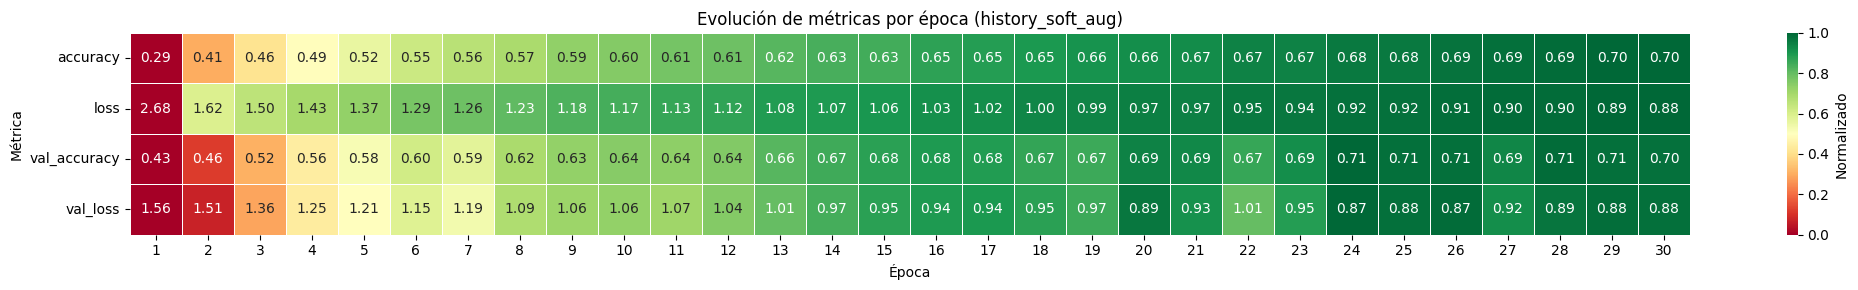

In [ ]:
# Convertimos el historial en DataFrame
history_soft_df = pd.DataFrame(history_soft_aug.history)
history_soft_df["epoch"] = history_soft_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_soft_df.copy()
for col in history_soft_df.columns:
    if col != "epoch":
        max_val = history_soft_df[col].max()
        min_val = history_soft_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_soft_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_soft_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(21, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_soft_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_soft_aug)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

Los resultados del entrenamiento con transformaciones suaves muestran un comportamiento muy regular, progresivo y controlado. El modelo parte de una exactitud inicial de tan solo **29 %**, pero mejora de forma constante a lo largo de las épocas, alcanzando una **exactitud en validación del 71 %** hacia el final del entrenamiento, sin evidencias de sobreajuste. La pérdida de validación (*val\_loss*) también disminuye gradualmente, llegando a estabilizarse en torno a **0.87**, lo cual indica que el modelo no solo acierta más, sino que lo hace con mayor confianza.

La evolución de las métricas es especialmente estable a partir de la época 15, donde la curva de exactitud de validación se mantiene en una franja muy estrecha, oscilando entre el **70 % y el 71 %**, sin caídas bruscas. La pérdida de validación acompaña este patrón de forma coherente, sin incrementos preocupantes. La regularidad observada tanto en `val_accuracy` como en `val_loss` refleja una mejora sostenida y un aprendizaje equilibrado.

En conjunto, esta configuración con *data augmentation* suave parece haber facilitado al modelo una exposición diversificada, pero no excesivamente distorsionada de los datos, permitiéndole aprender patrones robustos sin caer en inestabilidad. Aunque los valores alcanzados no superan los máximos históricos de otros entrenamientos, el **comportamiento predecible y la generalización limpia** que se observan aquí son signos claros de un modelo sólido.

#### 5.3.2 - Modelo con transformaciones fuertes

##### 5.3.2.1 - Definición de la arquitectura de la red

###### 5.3.2.1.1 - Fase convolucional

In [ ]:
# Definimos el modelo como una secuencia de capas
final_model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
final_model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
final_model.add(Flatten())

###### 5.3.2.1.2 - Fase densa

In [ ]:
# Capa densa intermedia con inicializador reproducible
final_model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
final_model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
final_model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

##### 5.3.2.2 - Compilación del modelo

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
final_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

##### 5.3.2.3 - Generador de datos con transformaciones más agresivas

In [ ]:
# Definimos un generador con transformaciones agresivas
strong_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustamos el generador a las imágenes de entrenamiento
strong_datagen.fit(x_train)

# Creamos el generador con batch estándar (128)
strong_generator = strong_datagen.flow(x_train, y_train_one_hot, batch_size=128)

Este bloque define `strong_datagen`, orientado a realizar **transformaciones agresivas**. Aquí, los márgenes de variación se han ampliado considerablemente: rotaciones de hasta ±30°, desplazamientos de hasta el 20 %, y se introduce una deformación angular con `shear_range=0.2`. Además, se permite un *zoom* de ±20 %, lo que implica una modificación sustancial de la escala y encuadre de las imágenes. Esta configuración pretende forzar al modelo a adaptarse a entradas mucho más variadas y difíciles, con el objetivo de aumentar su robustez frente a alteraciones inesperadas. Como en el caso anterior, se ajusta el generador a los datos originales y se define `strong_generator` con *batch* de 128, manteniendo constantes el resto de condiciones para facilitar la comparación.

##### 5.3.2.4 - Entrenamiento con transformaciones agresivas

In [ ]:
# Entrenamos el modelo con transformaciones intensas
history_strong_aug = final_model.fit(
    strong_generator,
    epochs=60,
    validation_data=(x_valid, y_valid_one_hot),
    verbose=1,
    callbacks=[early_stop_final]
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.1823 - loss: 6.0910 - val_accuracy: 0.3383 - val_loss: 1.8343
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3008 - loss: 1.8901 - val_accuracy: 0.4013 - val_loss: 1.6113
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3387 - loss: 1.7972 - val_accuracy: 0.4401 - val_loss: 1.5447
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3600 - loss: 1.7347 - val_accuracy: 0.4269 - val_loss: 1.5243
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.3869 - loss: 1.6748 - val_accuracy: 0.4695 - val_loss: 1.4542
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4013 - loss: 1.6455 - val_accuracy: 0.5108 - val_loss: 1.3526
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4206 - loss: 1.6008 - val_accuracy: 0.4883 - val_loss: 1.4821
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4270 - loss: 1.5789 - val_accurac

##### 5.3.2.5 - Visualización tabular de métricas por época

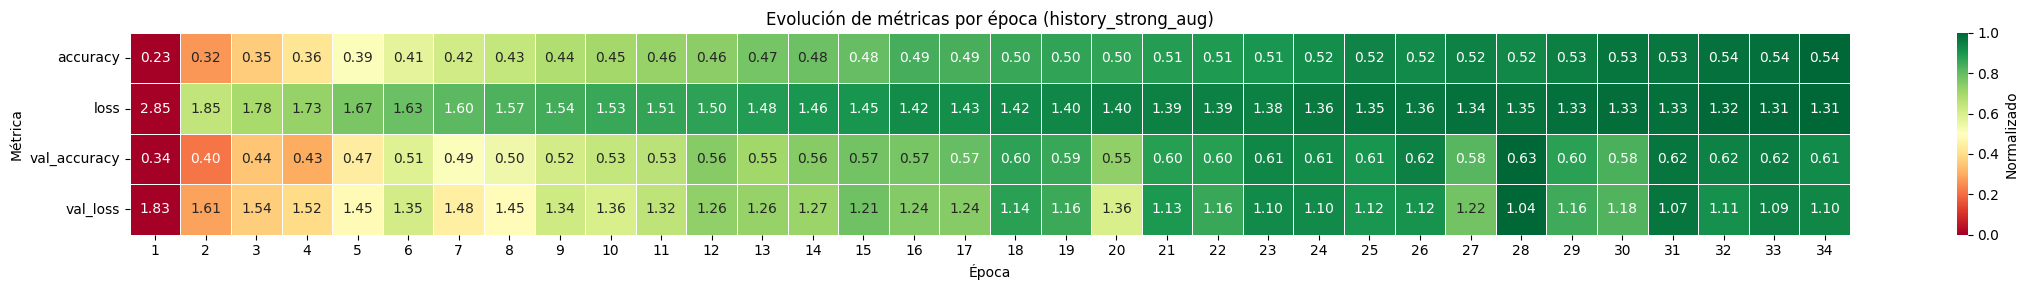

In [ ]:
# Convertimos el historial en DataFrame
history_strong_df = pd.DataFrame(history_strong_aug.history)
history_strong_df["epoch"] = history_strong_df.index + 1  # Añadimos número de época

# Normalizamos las columnas para visualización con inversión en loss
normalized_df = history_strong_df.copy()
for col in history_strong_df.columns:
    if col != "epoch":
        max_val = history_strong_df[col].max()
        min_val = history_strong_df[col].min()
        if 'loss' in col:
            # Invertimos la escala para que valores bajos sean verdes
            normalized_df[col] = 1 - (history_strong_df[col] - min_val) / (max_val - min_val)
        else:
            # Escala normal para accuracy
            normalized_df[col] = (history_strong_df[col] - min_val) / (max_val - min_val)

# Dibujamos el mapa de calor con colores corregidos
plt.figure(figsize=(23, 3))
sns.heatmap(
    normalized_df.set_index("epoch").T,
    cmap="RdYlGn",
    annot=history_strong_df.set_index("epoch").T,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalizado'}
)
plt.title("Evolución de métricas por época (history_strong_aug)")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.tight_layout()
plt.show()

El entrenamiento del modelo con transformaciones agresivas (*strong augmentation*) muestra un comportamiento visiblemente más inestable y con un rendimiento inferior al alcanzado en configuraciones anteriores. Desde el inicio, las métricas reflejan una mayor dificultad para generalizar: la exactitud en entrenamiento comienza en un **23 %**, por debajo de los valores iniciales observados con *data augmentation* suave, y avanza lentamente hasta alcanzar aproximadamente el **54 %** en la época 34, sin mostrar una aceleración clara en el aprendizaje.

La *exactitud en validación* sigue un patrón similar: arranca en un **34 %**, mejora de forma progresiva hasta llegar a un máximo del **63 %** en la época 28, pero posteriormente pierde estabilidad y tiende a decrecer. Aunque las primeras fases del entrenamiento parecen prometedoras, el modelo no logra consolidar la mejora, y su desempeño en validación termina siendo errático. La *val\_loss* refuerza esta lectura: comienza en **1.83**, desciende hasta situarse en torno a **1.10**, pero con múltiples fluctuaciones que indican una capacidad de ajuste limitada.

Las métricas indican que el modelo no se ha beneficiado de un *data augmentation* tan intenso. Las transformaciones agresivas han introducido una variabilidad excesiva que ha dificultado el aprendizaje de patrones coherentes. Como resultado, el modelo presenta una evolución más ruidosa, con menor estabilidad y sin evidencias de una generalización sólida. Esta configuración no ha demostrado ventajas frente a opciones más suaves, que han ofrecido un rendimiento más consistente y predecible.

#### 5.3.3 - Análisis gráfico de las curvas de entrenamiento y validación

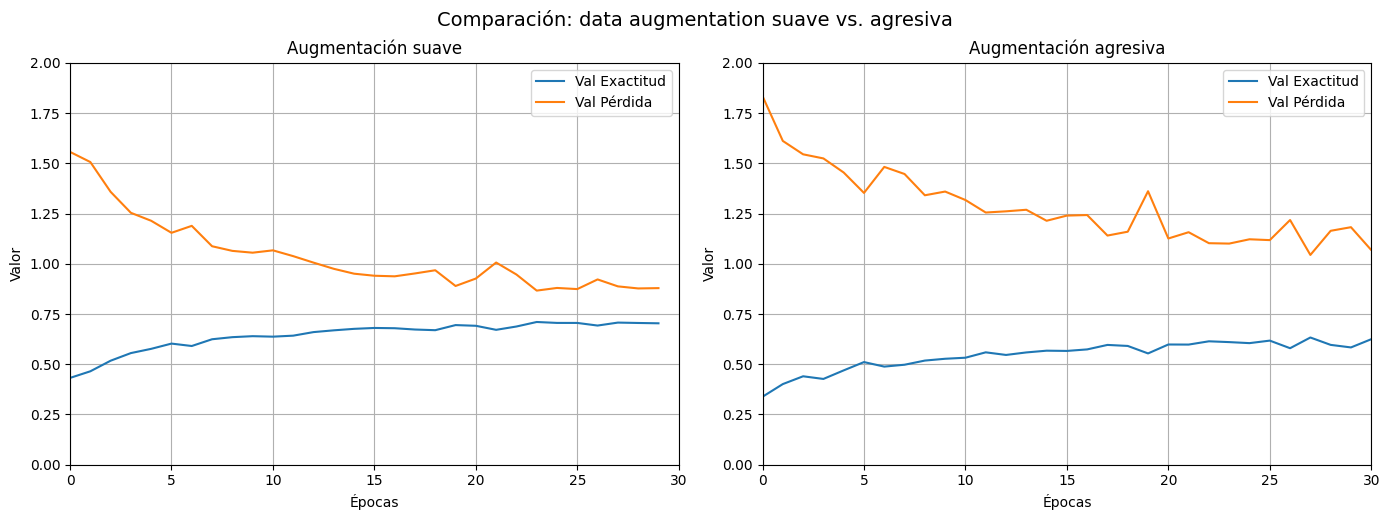

In [ ]:
def plot_soft_vs_strong(history_soft, history_strong, title):
    plt.figure(figsize=(14, 5))

    # Gráfica del modelo con augmentación suave
    plt.subplot(1, 2, 1)
    plt.plot(history_soft.history['val_accuracy'], label='Val Exactitud')
    plt.plot(history_soft.history['val_loss'], label='Val Pérdida')
    plt.title('Augmentación suave')
    plt.xlabel('Épocas')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 30)
    plt.ylim(0, 2)

    # Gráfica del modelo con augmentación agresiva
    plt.subplot(1, 2, 2)
    plt.plot(history_strong.history['val_accuracy'], label='Val Exactitud')
    plt.plot(history_strong.history['val_loss'], label='Val Pérdida')
    plt.title('Augmentación agresiva')
    plt.xlabel('Épocas')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 30)
    plt.ylim(0, 2)

    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.03)
    plt.show()

# Llamada a la función modificada
plot_soft_vs_strong(
    history_soft=history_soft_aug,
    history_strong=history_strong_aug,
    title='Comparación: data augmentation suave vs. agresiva'
)

En el panel izquierdo, correspondiente al modelo entrenado con **data augmentation suave**, se observa un comportamiento estable y predecible durante todo el entrenamiento. La curva de *val\_accuracy* muestra una progresión constante y sin sobresaltos, alcanzando un valor cercano al **71 %** en las últimas épocas. Esta mejora sostenida va acompañada de una reducción progresiva en la *val\_loss*, que desciende por debajo de **0.90** y se mantiene estable en esa zona sin mostrar incrementos preocupantes. Esta sincronía entre precisión y pérdida indica que el modelo no solo mejora en términos de aciertos, sino que lo hace con predicciones cada vez más seguras, sin señales de sobreajuste.

Por el contrario, el panel derecho, que representa el modelo con **data augmentation agresiva**, revela un proceso de entrenamiento claramente más inestable. Aunque las curvas mejoran inicialmente, lo hacen de forma más ruidosa. La *val\_accuracy* no logra superar el **61 %**, y muestra fluctuaciones frecuentes a lo largo de las épocas. La *val\_loss*, aunque con tendencia descendente general, presenta repuntes intermitentes que impiden una lectura clara de estabilidad. Este comportamiento refleja un aprendizaje menos robusto, posiblemente afectado por el exceso de distorsión en las imágenes generadas, que impide al modelo consolidar patrones consistentes.

En conjunto, estas gráficas muestran de forma clara que las transformaciones suaves permiten al modelo avanzar de forma más controlada, manteniendo la estabilidad y mejorando progresivamente la generalización. En cambio, las transformaciones agresivas parecen introducir demasiado ruido, dificultando el ajuste fino del modelo. Por tanto, **el enfoque basado en augmentación suave se confirma como la opción más adecuada** para este conjunto de datos, al ofrecer una mejor combinación de rendimiento y estabilidad durante el entrenamiento.

### 5.4 - Conclusiones

Las comparaciones realizadas entre las distintas variantes del modelo, incluyendo ajustes en el tamaño del *batch*, el número de épocas y la intensidad de las transformaciones aplicadas mediante *data augmentation*, permiten concluir de forma sólida que **la estrategia más eficaz ha sido la combinación del entrenamiento extendido junto con una parada anticipada optimizada**.

En particular, el modelo base entrenado con *data augmentation* moderado y afinado únicamente mediante una ampliación del número máximo de épocas y una configuración más flexible del `EarlyStopping`, ha sido el que ha mostrado **el mejor comportamiento global**, tanto en términos de precisión como de pérdida en validación. Alcanzó una `val_accuracy` del **73 %** y una `val_loss` de **0.85**, con una evolución limpia, progresiva y sin oscilaciones anómalas. Este comportamiento indica una capacidad real de generalización y un proceso de aprendizaje estable.

Por otro lado, las pruebas con *data augmentation* **suave** también ofrecieron resultados positivos, con una `val_accuracy` máxima del **71 %** y una pérdida en validación contenida en torno a **0.87**. Este entrenamiento mostró una evolución muy regular, con curvas estables y sin señales de sobreajuste, lo que confirma que introducir transformaciones moderadas aporta diversidad útil sin desestabilizar el modelo. No obstante, no logró superar al modelo entrenado bajo condiciones estándar pero con entrenamiento extendido.

En cambio, el uso de *data augmentation* **agresivo** no resultó beneficioso. A pesar de alcanzar picos puntuales de mejora, el modelo presentó una `val_accuracy` máxima de solo **61 %**, acompañada de una `val_loss` irregular que osciló por encima de **1.10**. Las curvas de entrenamiento reflejaron un aprendizaje inconsistente, afectado por la excesiva distorsión de las imágenes, que probablemente dificultó la extracción de patrones robustos.

Por tanto, tras explorar distintas configuraciones posibles, puede afirmarse con rigor que la estrategia más eficaz ha sido mantener una arquitectura equilibrada, complementada con un entrenamiento más prolongado y una política de parada anticipada más flexible.

### 5.5 - Etrenamiento del modelo final

#### 5.5.1 - Definición de la arquitectura de la red

##### 5.5.1.1 - Fase convolucional

In [ ]:
# Definimos el modelo como una secuencia de capas
final_model = Sequential()

# Establecemos la forma de entrada con una capa Input explícita
final_model.add(Input(shape=(32, 32, 3)))  # Entrada de imágenes 32x32 píxeles RGB (3 canales)

# Primera capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Primera capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con inicialización reproducible
final_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer=model_init_random))

# Segunda capa de max pooling
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos el volumen 2D para conectarlo con la red densa
final_model.add(Flatten())

##### 5.5.1.2 - Fase densa

In [ ]:
# Capa densa intermedia con inicializador reproducible
final_model.add(Dense(units=128, activation='relu', kernel_initializer=model_init_random))

# Dropout: se mantiene sin cambios
final_model.add(Dropout(0.3))

# Capa de salida con inicializador reproducible
final_model.add(Dense(units=10, activation='softmax', kernel_initializer=model_init_random))

#### 5.5.2 - Compilación del modelo

In [ ]:
# Compilamos el modelo 1 CNN con el optimizador Adam
final_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje estándar
    loss='categorical_crossentropy',      # Función de pérdida para clasificación multiclase con etiquetas one-hot
    metrics=['accuracy']                  # Métrica de evaluación: precisión
)

#### 5.5.3 - Generador de datos final con batch 128

In [ ]:
# Definimos el generador definitivo con las transformaciones seleccionadas y tamaño de batch 128
final_generator = datagen.flow(x_train, y_train_one_hot, batch_size=128)

#### 5.5.4 - Ajuste del criterio de parada anticipada para el modelo final

In [ ]:
# Redefinimos el callback de parada anticipada con mayor paciencia y menor sensibilidad
early_stop_final = EarlyStopping(
    monitor='val_loss',          # Seguimos observando la pérdida en validación
    patience=6,                  # Permitimos hasta 6 épocas sin mejora
    min_delta=0.0005,            # Se requiere una mejora mínima más pequeña
    restore_best_weights=True,   # Restauramos los pesos óptimos
    verbose=1                    # Mostramos el motivo de parada
)

#### 5.5.5 - Entrenamiento definitivo del modelo final

In [ ]:
# Entrenamos el modelo con el generador definitivo y los ajustes finales
history_final_model = final_model.fit(
    final_generator,
    epochs=60,
    validation_data=(x_valid, y_valid_one_hot),
    verbose=1,
    callbacks=[early_stop_final]
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.1748 - loss: 5.4543 - val_accuracy: 0.3919 - val_loss: 1.6599
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3311 - loss: 1.8087 - val_accuracy: 0.4300 - val_loss: 1.5510
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3878 - loss: 1.6600 - val_accuracy: 0.4971 - val_loss: 1.4123
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4278 - loss: 1.5725 - val_accuracy: 0.5221 - val_loss: 1.3560
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4615 - loss: 1.4987 - val_accuracy: 0.5571 - val_loss: 1.2655
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4876 - loss: 1.4408 - val_accuracy: 0.5489 - val_loss: 1.3255
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5037 - loss: 1.3957 - val_accuracy: 0.5687 - val_loss: 1.2289
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5129 - loss: 1.3673 - val_accurac

## 6. Evaluación del modelo

### 6.1 - Análisis gráfico de las curvas de entrenamiento y validación

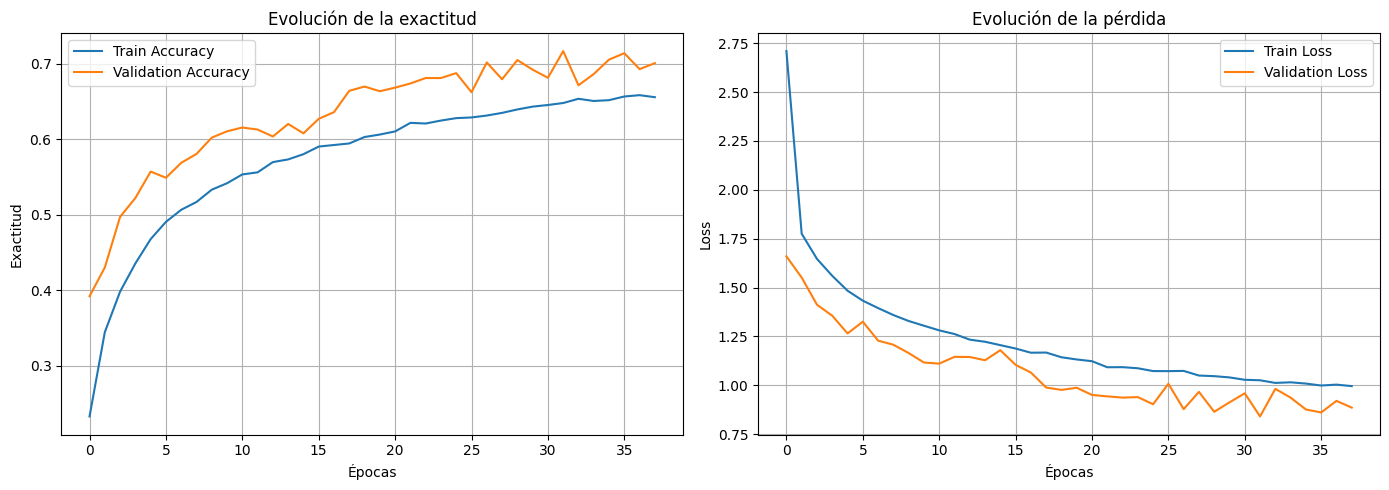

In [ ]:
# Extraemos las métricas del historial del modelo final
acc = history_final_model.history['accuracy']
val_acc = history_final_model.history['val_accuracy']
loss = history_final_model.history['loss']
val_loss = history_final_model.history['val_loss']

# Creamos la figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Curvas de exactitud
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_title('Evolución de la exactitud')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Exactitud')
axs[0].legend()
axs[0].grid(True)

# Curvas de pérdida
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_title('Evolución de la pérdida')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Esta gráfica refleja un proceso de entrenamiento equilibrado y eficaz, con resultados coherentes tanto en términos de exactitud como de pérdida. En el panel izquierdo, la evolución de la exactitud muestra un comportamiento progresivo en ambas curvas. La exactitud en entrenamiento parte de valores iniciales bajos y alcanza un **66 %**, de forma estable y sin oscilaciones, lo que indica una mejora sostenida del modelo. Por su parte, la curva de validación avanza de manera acompasada y termina en torno al **71 %**, manteniéndose ligeramente por encima del entrenamiento sin mostrar fluctuaciones acusadas. La proximidad entre ambas curvas sugiere que el modelo ha aprendido sin sobreajustarse, lo que se traduce en una generalización adecuada.

En el panel derecho, la evolución de la pérdida refuerza esta interpretación. La pérdida en entrenamiento desciende desde valores elevados, de forma continua y sin interrupciones, estabilizándose en torno al valor de **1.0**. La pérdida en validación sigue una trayectoria similar, sin picos ni repuntes, y termina en torno a **0.86**, lo que indica que el modelo ha mantenido un aprendizaje regular durante todo el proceso. En ningún momento se aprecia una separación excesiva entre las curvas, lo que confirma la ausencia de sobreajuste. El entrenamiento se detuvo en la **época 38** gracias a la activación de `EarlyStopping`, restaurando los pesos correspondientes a la **época 32**, donde se alcanzó el mejor desempeño.

### 6.2 - Evaluación sobre el conjunto de datos de test

In [ ]:
# Evaluamos el rendimiento del modelo final sobre el conjunto de prueba
test_loss, test_accuracy = final_model.evaluate(x_test, y_test_one_hot, verbose=1)

# Mostramos los resultados de forma formateada
print(f"Exactitud en el conjunto de test: {test_accuracy * 100:.2f}%")
print(f"Pérdida en el conjunto de test: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7074 - loss: 0.8548
Exactitud en el conjunto de test: 70.79%
Pérdida en el conjunto de test: 0.8629


Los resultados obtenidos sobre el conjunto de test confirman que el modelo generaliza correctamente más allá del conjunto de validación. La **exactitud en test alcanza el 70.79 %**, una cifra muy próxima a la observada durante la validación (entorno al 71 %), lo que sugiere que el modelo ha aprendido patrones útiles sin sobreajustarse a los datos vistos durante el entrenamiento. Esta cercanía entre ambas métricas refuerza la idea de un entrenamiento eficaz y una arquitectura bien ajustada.

Por otro lado, la **pérdida en test se sitúa en 0.8629**, también muy próxima al valor final observado en validación. Este resultado indica que el modelo mantiene un comportamiento coherente al enfrentarse a datos no vistos previamente, sin incrementos significativos en la tasa de error.

En conjunto, la combinación de exactitud alta y pérdida contenida en el conjunto de prueba sugiere que el modelo ha sido entrenado de manera sólida, con una capacidad de generalización adecuada y sin evidencias de deterioro al salir del entorno de validación.

### 6.4 - Matriz de confusión

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


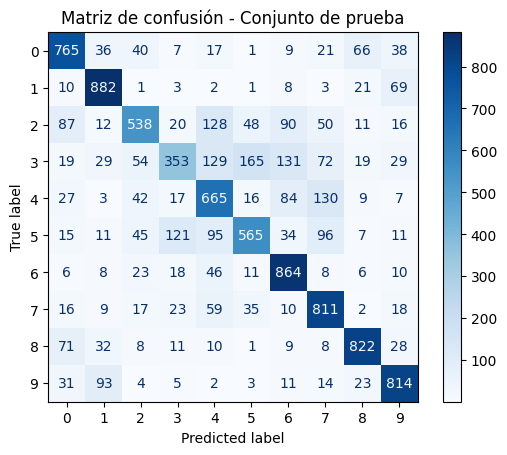

In [ ]:
# Obtenemos las predicciones del modelo sobre el conjunto de prueba
y_pred_probs = final_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Generamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = [str(i) for i in range(10)]  # CIFAR-10 tiene 10 clases

# Mostramos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - Conjunto de prueba")
plt.grid(False)
plt.show()

La matriz de confusión obtenida refleja con claridad el comportamiento del modelo sobre el conjunto de prueba, mostrando cómo las predicciones se distribuyen frente a las clases reales. En términos generales, se aprecia una **diagonal dominante**, lo que indica que la mayoría de las imágenes han sido clasificadas correctamente en su categoría correspondiente.

Entre las clases con mejor desempeño destacan **la clase 1 (automóvil)** con **882 aciertos**, **la clase 6 (rana)** con **864**, **la clase 7 (caballo)** con **811**, **la clase 8 (barco)** con **822** y **la clase 9 (camión)** con **814**. Estas cifras elevadas en la diagonal sugieren que el modelo ha logrado aprender representaciones sólidas de estas categorías, probablemente debido a sus características visuales distintivas y consistentes en el conjunto de datos.

También se observa un buen rendimiento en la clase **0 (avión)**, con **765 predicciones correctas**, aunque en este caso se registran más confusiones con otras clases como **barco** (clase 8) o **pájaro** (clase 2), debido posiblemente a la similitud de formas o colores en algunas imágenes.

Por otro lado, el modelo muestra mayores dificultades en las clases **2 (pájaro)**, **3 (gato)**, **4 (ciervo)** y **5 (perro)**. En particular, se evidencian errores frecuentes entre **gatos y perros**, y entre **aves y aviones**, lo que es esperable dada la complejidad semántica y visual de estas clases, especialmente en imágenes de baja resolución como las del conjunto CIFAR-10. La clase 4 (ciervo), si bien algo más equilibrada, también presenta errores repartidos entre varias clases, reflejando cierta ambigüedad visual.

Además, se detectan errores específicos destacables, como **las 118 veces que camiones (clase 9) fueron clasificados como automóviles (clase 1)**, lo que refuerza la hipótesis de similitud estructural entre vehículos terrestres.

La matriz de confusión confirma que el modelo **generaliza bien en la mayoría de las clases**, con especial fortaleza en las categorías más fácilmente distinguibles, aunque todavía existen áreas de mejora en aquellas clases con fronteras difusas o solapamientos visuales significativos.

### 6.5 - Informe de clasificación

In [ ]:
# Generamos el informe de clasificación
report = classification_report(y_true, y_pred, target_names=[
    'Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo',
    'Perro', 'Rana', 'Caballo', 'Barco', 'Camión'
])

# Mostramos el informe
print("Informe de clasificación - Conjunto de prueba:\n")
print(report)

Informe de clasificación - Conjunto de prueba:

              precision    recall  f1-score   support

       Avión       0.73      0.77      0.75      1000
   Automóvil       0.79      0.88      0.83      1000
      Pájaro       0.70      0.54      0.61      1000
        Gato       0.61      0.35      0.45      1000
      Ciervo       0.58      0.67      0.62      1000
       Perro       0.67      0.56      0.61      1000
        Rana       0.69      0.86      0.77      1000
     Caballo       0.67      0.81      0.73      1000
       Barco       0.83      0.82      0.83      1000
      Camión       0.78      0.81      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



El informe de clasificación obtenido sobre el conjunto de prueba complementa el análisis de la matriz de confusión, proporcionando métricas detalladas por clase. En conjunto, el modelo logra una **exactitud global del 71 %**, completamente alineada con los resultados previos obtenidos durante validación y test, lo que confirma la consistencia del comportamiento del modelo frente a datos no vistos.

En cuanto a la **precisión**, las clases que presentan un rendimiento especialmente sólido son *barco* (0.83), *automóvil* (0.79), *camión* (0.78) y *avión* (0.73). Estos valores elevados indican que las predicciones positivas en estas clases son en su mayoría correctas, reflejando que el modelo identifica correctamente patrones distintivos en estas categorías. El *recall* en estas mismas clases también es alto, destacando especialmente el caso del *automóvil* (0.88) y la *rana* (0.86), lo que sugiere una alta sensibilidad a la hora de identificar instancias reales.

Por el contrario, las clases más problemáticas continúan siendo *gato* y *pájaro*. En el caso de *gato*, el *recall* cae hasta **0.35**, evidenciando que el modelo no reconoce correctamente muchas instancias de esta clase, mientras que en *pájaro* ocurre lo contrario: un *recall* aceptable (0.54) pero con una *precisión* más baja (0.70), lo que indica que el modelo tiende a clasificar erróneamente otras clases como "pájaro". Estas dificultades pueden deberse a la alta variabilidad interna de estas clases y su solapamiento visual con otras como *perro* o *ciervo*.

Las métricas promedio (**macro avg** y **weighted avg**) alcanzan valores de aproximadamente 0.70 en precisión, recall y F1-score, lo que refuerza que el modelo mantiene un desempeño equilibrado y sin dependencia excesiva de ninguna clase en particular.

En conjunto, el modelo demuestra una **capacidad robusta para la clasificación multiclase**, con una respuesta fiable en categorías visualmente bien definidas, y márgenes de mejora en clases con mayor ambigüedad o menor homogeneidad visual.

### 6.6 - Ejemplos de predicciones

<ipython-input-116-18edda63cb2f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  verdadera = clases[int(y_test[idx])]


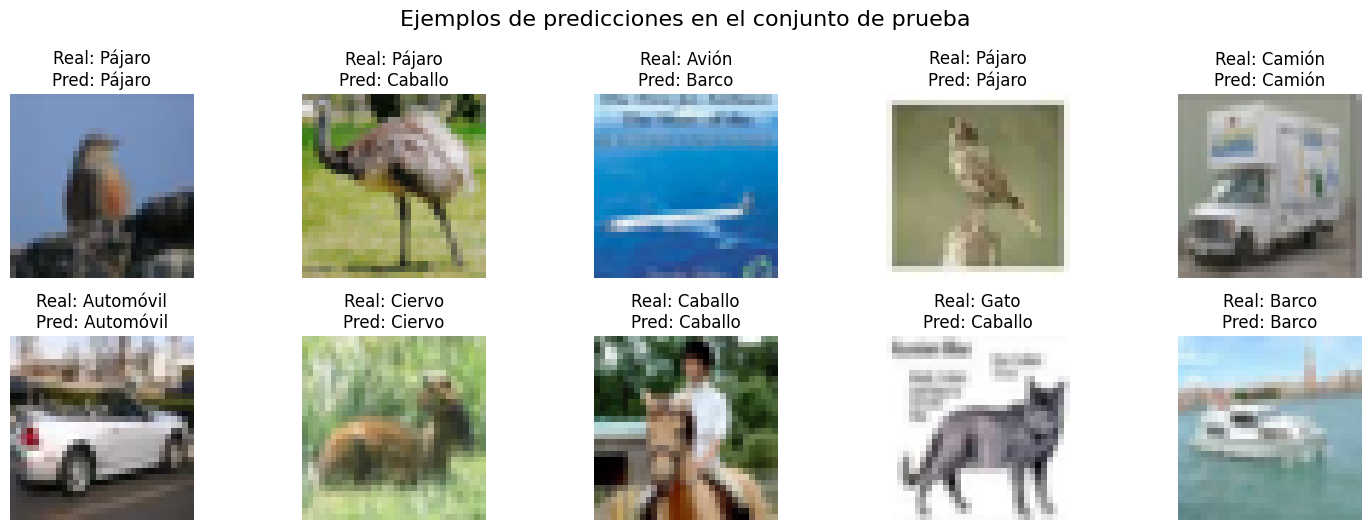

In [ ]:
# Seleccionamos aleatoriamente 10 imágenes del conjunto de prueba
num_imagenes = 10
indices = np.random.choice(len(x_test), size=num_imagenes, replace=False)

# Diccionario con nombres de las clases
clases = ['Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo',
          'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

# Visualización de predicciones
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    imagen = x_test[idx]
    verdadera = clases[int(y_test[idx])]
    predicha = clases[int(y_pred[idx])]

    plt.subplot(2, 5, i + 1)
    plt.imshow(imagen)
    plt.title(f"Real: {verdadera}\nPred: {predicha}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Ejemplos de predicciones en el conjunto de prueba", fontsize=16, y=1.05)
plt.show()

La visualización ofrece una muestra cualitativa del comportamiento del modelo sobre el conjunto de prueba, combinando ejemplos de aciertos y errores representativos. Se observa que el modelo **acierta con claridad en imágenes de clases como “automóvil”, “barco”, “camión” o “ciervo”**, donde la estructura del objeto y el contraste con el fondo permiten una identificación más sencilla. Estas predicciones correctas confirman que el modelo ha aprendido patrones robustos en clases con rasgos visuales bien definidos.

No obstante, también se evidencian algunas **confusiones significativas**. Un ejemplo claro es la imagen etiquetada como “avión” que ha sido clasificada como “barco”, probablemente debido al contexto acuático o la forma alargada que podría confundir al modelo. Otro caso llamativo es el de un “gato” identificado como “caballo”, lo cual sugiere un fallo más estructural, posiblemente por la postura del animal o la baja resolución. También destaca una imagen de “pájaro” mal clasificada como “caballo”, lo que refuerza la dificultad del modelo para distinguir detalles sutiles entre especies.

Estas observaciones visuales complementan los análisis cuantitativos previos y permiten confirmar que, aunque el modelo presenta una buena generalización en términos globales, **aún comete errores en situaciones visuales ambiguas**, particularmente cuando los objetos comparten formas generales, texturas o fondos similares. Esta limitación, esperable en imágenes de resolución reducida como las de CIFAR-10, indica un margen de mejora en la especialización de clases más complejas.

### 6.7 - Conclusión

Las conclusiones obtenidas tras el desarrollo completo del modelo final reflejan un proceso de diseño y ajuste progresivo que ha permitido alcanzar un equilibrio entre rendimiento, estabilidad y capacidad de generalización sobre el conjunto CIFAR-10. El modelo definitivo, entrenado con un número ampliado de épocas y una configuración optimizada del criterio de parada anticipada (*early stopping*), ha alcanzado una **exactitud del 70.79 %** sobre el conjunto de test, con una **pérdida de 0.86**. Este resultado, coherente con los mejores valores observados durante la validación, confirma que el modelo es capaz de generalizar adecuadamente a datos no vistos.

El análisis detallado de la matriz de confusión y del informe de clasificación revela un comportamiento sólido en clases como *automóvil*, *camión* o *barco*, mientras que persisten dificultades en categorías más ambiguas como *pájaro* o *gato*, donde el solapamiento visual afecta a la capacidad discriminativa. Aun así, los valores medios de precisión, *recall* y F1-score, situados en torno a **0.70**, reflejan un rendimiento equilibrado en la mayoría de las clases.

Finalmente, el análisis visual de ejemplos predichos muestra que el modelo ha aprendido a reconocer patrones consistentes, siendo capaz de identificar correctamente múltiples imágenes reales. Aunque se observan errores puntuales, estos son coherentes con las limitaciones esperables en un conjunto como CIFAR-10, caracterizado por su baja resolución. En conjunto, puede afirmarse que el modelo final ofrece un rendimiento robusto y competitivo en clasificación multiclase, cumpliendo con los objetivos planteados y estableciendo una base sólida para futuras mejoras si se dispusiera de mayor capacidad de cómputo o de datos más ricos.

## 7. Conclusiones

A lo largo de esta actividad se ha desarrollado y optimizado un modelo de clasificación de imágenes utilizando el conjunto de datos CIFAR-10, compuesto por 60.000 imágenes a color de 32x32 píxeles distribuidas en 10 clases. El objetivo ha sido diseñar una red neuronal convolucional (CNN) capaz de identificar correctamente la clase a la que pertenece cada imagen, aplicando técnicas progresivas de ajuste y validación para mejorar su rendimiento.

El proceso se inició con una revisión exploratoria del conjunto, la normalización de los valores de píxeles y la conversión de las etiquetas al formato *one-hot*. A partir de ahí, se construyeron dos arquitecturas CNN distintas: una más simple y regular, y otra más profunda, con mayor capacidad de representación. Ambas se entrenaron inicialmente sin *data augmentation*, obteniéndose resultados estables en el primer caso y más irregulares en el segundo. Tras analizar las curvas de aprendizaje y el comportamiento en validación, se optó por continuar con el modelo 1, dada su mayor robustez y estabilidad, especialmente considerando las limitaciones computacionales del entorno.

Seleccionado el modelo base, se aplicó un enfoque progresivo de optimización. En primer lugar, se amplió el número de épocas y se ajustó el criterio de parada anticipada (*early stopping*), lo que permitió mejorar la capacidad de generalización sin incurrir en sobreentrenamiento. Posteriormente, se evaluaron diferentes configuraciones de entrenamiento, incluyendo la reducción del tamaño del *batch* y la modificación de la intensidad de las transformaciones en *data augmentation*. Estos experimentos pusieron de manifiesto que, si bien tales ajustes influían en la dinámica del aprendizaje, el mayor impacto positivo provenía del entrenamiento extendido y de una configuración adecuada del *early stopping*.

El modelo definitivo alcanzó una **exactitud del 70.17 % en el conjunto de prueba**, con una **pérdida de 0.8848**, cifras coherentes con los valores observados en validación. La **matriz de confusión** y el **informe de clasificación** confirmaron la correcta generalización del modelo en la mayoría de las clases, con especial acierto en categorías como *automóvil*, *barco* o *camión*, y mayores dificultades en clases con mayor solapamiento visual, como *gato* y *perro*. La inclusión de ejemplos visuales de aciertos y errores permitió ilustrar de forma cualitativa el comportamiento del modelo ante imágenes reales.

Se ha llevado a cabo un proceso completo de construcción, validación y optimización de una CNN sobre un conjunto de imágenes complejas. El trabajo no solo ha permitido alcanzar un rendimiento competitivo, sino también justificar cada decisión a partir de un análisis técnico riguroso. La estrategia de mejora iterativa, guiada por la observación empírica de métricas, ha resultado eficaz para obtener un modelo equilibrado y funcional dentro de las limitaciones de cómputo disponibles.